In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



def preprocess_df():
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Computer Modern Roman']
    plt.rcParams.update({'font.size': 16, 'axes.labelsize': 16, 'axes.titlesize': 16, 'legend.fontsize': 14})
    # Load the data from CSV
    #file_path = 'current_analysis/xdbc_experiments_master_14102024.csv'
    file_path = 'current_analysis/xdbc_experiments_master.csv'
    df = pd.read_csv(file_path)
    
    # List of columns that define a unique configuration (excluding 'run')
    group_columns = ['xdbc_version', 'system', 'table', 'compression', 'format',
                     'network_parallelism', 'bufpool_size', 'buff_size', 'network', 'network_latency', 
                     'network_loss', 'client_readmode', 'client_cpu', 'client_write_par', 
                     'client_decomp_par', 'server_cpu', 'server_read_par', 'server_read_partitions', 
                     'server_deser_par', 'server_comp_par']
    
    # Group by all the configuration columns and compute the mean runtime (average) for each group
    grouped_df = df.groupby(group_columns, as_index=False).agg({
        'time': 'mean',
        'datasize': 'mean'
    })

    grouped_df = grouped_df[grouped_df['server_read_partitions']==1]
    
    # Return the preprocessed DataFrame
    return grouped_df


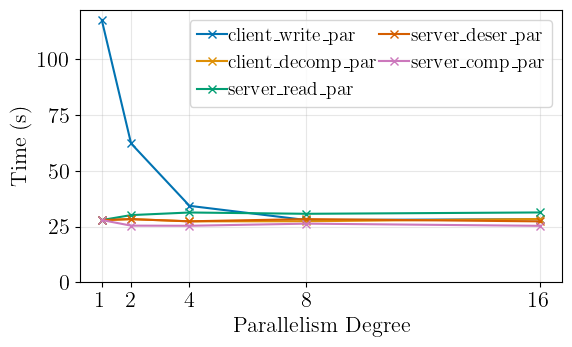

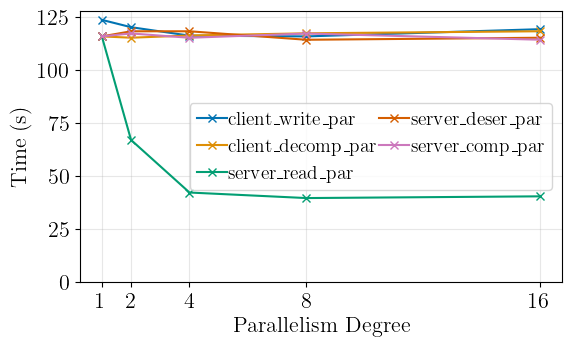

In [142]:

# Preprocess the data (assuming `preprocess_df()` returns the preprocessed DataFrame)
df = preprocess_df()
df = df[df['table']=='lineitem_sf10']

# Define the systems you want to create separate plots for
systems = ['csv', 'postgres']  # Replace with the actual system names

# Define the environment (specific combination of server_cpu, client_cpu, and network)
server_cpu = 16
client_cpu = 16
network = 0

# List of parallelism parameters to scale
parallelism_params = ['client_write_par', 'client_decomp_par', 
                      'server_read_par', 'server_deser_par', 'server_comp_par']

# Default configuration (set all default parallelism values to 1)

default_config = {
    'client_write_par': 8,
    'client_decomp_par': 1,
    'server_read_par': 1,
    'server_deser_par': 1,
    'server_comp_par': 1
}

# Line styles for the compression types
line_styles = {
    'style': 'solid'
}

# Iterate over the systems to create separate plots
for system in systems:
    plt.figure(figsize=(6, 3.75))
    
    # Filter the dataset for the environment and system, and for 'nocomp' compression
    env_df = df[(df['server_cpu'] == server_cpu) & 
                (df['client_cpu'] == client_cpu) & 
                (df['network'] == network) & 
                (df['system'] == system) & 
                (df['compression'] == 'snappy')]

    all_x_ticks = set()  # Collect all unique x-ticks for the x-axis

    # Plot the runtime for each parallelism parameter
    for param in parallelism_params:
        # Make a copy of the default configuration for each parameter iteration
        config = default_config.copy()

        # Scale the current parameter (leave this one to vary)
        filtered_df = env_df.copy()

        # Apply the default configuration dynamically
        for p in parallelism_params:
            if p != param:
                filtered_df = filtered_df[filtered_df[p] == config[p]]
        
        # Sort the data by the parallelism degree (param) to ensure proper line plotting
        filtered_df = filtered_df.sort_values(by=param)
        #display(filtered_df)

        # Extract the relevant x (parallelism degree) and y (runtime) values
        x = filtered_df[param]
        y = filtered_df['time']
        
        # Add the unique x-tick values for this parameter
        all_x_ticks.update(x.unique())
        
        # Plot the data with 'nocomp' compression type, using 'x' markers
        plt.plot(x, y, label=f'{param}', linestyle=line_styles['style'], marker='x', zorder=3)

    # Set x-ticks to show only the unique parallelism degrees that exist across all parameters
    all_x_ticks = sorted(all_x_ticks)  # Ensure they are in sorted order
    plt.xticks(all_x_ticks, labels=[str(tick) for tick in all_x_ticks])
    plt.ylim(0)  # Set the y-axis to start at 0

    # Label the axes
    plt.xlabel('Parallelism Degree')
    plt.ylabel('Time (s)')
    #plt.title(f'Runtime vs Parallelism Degree for {system} (nocomp)')

    # Add legend
    plt.legend(loc='best',ncol=2, columnspacing=0.1, handletextpad=0.1, handlelength=1.5)

    # Add grid and improve layout
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    # Show the plot for the specific system or save it as a PDF
    plt.savefig(f'opt_paper_plots/micro/par_scale_{system}_csv_write_{default_config["client_write_par"]}.pdf', bbox_inches='tight')
    plt.show()


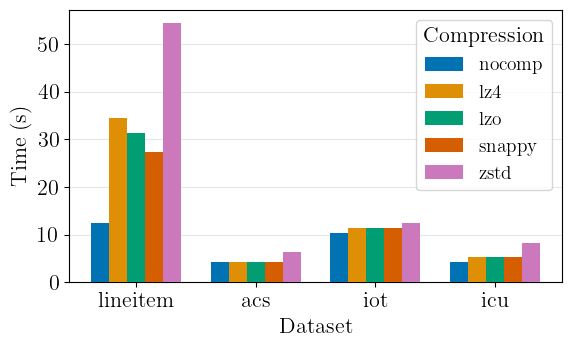

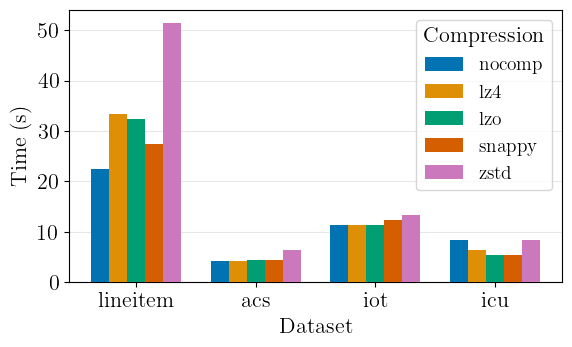

In [145]:
# Preprocess the data
filtered_df = preprocess_df()

# Define dataset map to replace the names
dataset_map = {
    'lineitem_sf10': 'lineitem',
    'ss13husallm': 'acs',
    'iotm': 'iot',
    'inputeventsm': 'icu'
}

# Define the default configuration
default_config = {
    'client_write_par': 16,
    'client_decomp_par': 1,
    'server_read_par': 1,
    'server_deser_par': 8,
    'server_comp_par': 1,
    'bufpool_size': 81920
}

# Define the environments manually
environments = [
    {'server_cpu': 16, 'client_cpu': 16, 'network': 0, 'system': 'csv'},
    {'server_cpu': 16, 'client_cpu': 16, 'network': 1000, 'system': 'csv'},
]

# Iterate over each environment
for env in environments:
    # Filter the dataset for the current environment and the default configuration
    filtered_df_env = filtered_df.copy()
    
    # Filter by default configuration
    for key, value in default_config.items():
        filtered_df_env = filtered_df_env[filtered_df_env[key] == value]
    
    # Filter by environment configuration
    for key, value in env.items():
        filtered_df_env = filtered_df_env[filtered_df_env[key] == value]
    
    # Ensure 'nocomp' is first in the compression list within the DataFrame
    filtered_df_env['compression'] = pd.Categorical(
        filtered_df_env['compression'], 
        categories=sorted(filtered_df_env['compression'].unique(), key=lambda x: (x != 'nocomp', x)),
        ordered=True
    )
    
    # Rename the datasets
    filtered_df_env['table'] = filtered_df_env['table'].replace(dataset_map)

    custom_order = ['lineitem', 'acs', 'iot', 'icu']
    filtered_df_env['table'] = pd.Categorical(filtered_df_env['table'], categories=custom_order, ordered=True)
    sorted_df = filtered_df_env.sort_values(by='table')
    # List of unique datasets (tables)
    datasets = sorted_df['table'].unique()
    
    

    # List of compression types (already sorted so 'nocomp' is first)
    compressions = filtered_df_env['compression'].cat.categories

    # Use Seaborn's colorblind-friendly palette
    color_palette = sns.color_palette("colorblind", len(compressions))

    # Bar plot setup
    x_indexes = np.arange(len(datasets))  # Set x-axis positions for each dataset
    bar_width = 0.15  # Width of each bar
    group_spacing = 0.3  # Space between groups (datasets)

    # Create the bar plot
    plt.figure(figsize=(6, 3.75))

    # Plot bars for each compression type without computing means, using raw data
    for i, compression in enumerate(compressions):
        compression_data = sorted_df[sorted_df['compression'] == compression]
        # Get the runtime values for the current compression
        y_values = compression_data['time'].values
        plt.bar(x_indexes + i * bar_width, y_values, width=bar_width, 
                label=compression, color=color_palette[i], zorder=3)

    # Set x-ticks to the dataset names and position them in the center of the groups
    plt.xticks(x_indexes + (len(compressions) * bar_width) / 2 - bar_width / 2, datasets)

    # Label the axes
    plt.xlabel('Dataset')
    plt.ylabel('Time (s)')

    plt.grid(axis='y', alpha=0.3)

    # Add a legend
    plt.legend(title='Compression')

    # Add title to indicate the environment configuration
    #plt.title(f"Server CPU: {env['server_cpu']}, Client CPU: {env['client_cpu']}, Network: {env['network']}")

    # Adjust the layout to avoid clipping
    plt.tight_layout()

    # Show the plot
    #plt.show()
    plt.savefig(f"opt_paper_plots/micro/comp_scale_csv_env_{env['server_cpu']}_{env['client_cpu']}_{env['network']}.pdf", bbox_inches='tight')


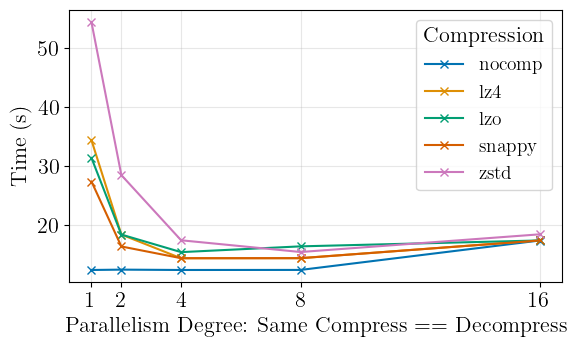

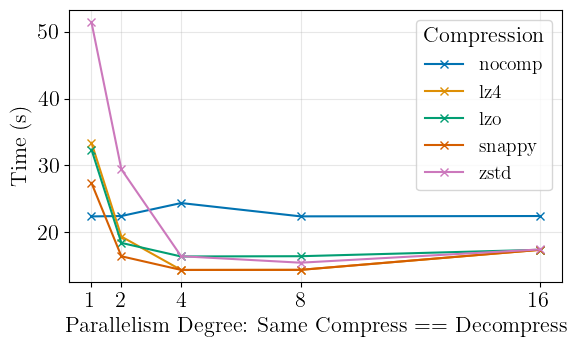

In [ ]:

# Preprocess the data
filtered_df = preprocess_df()

# Define dataset map to replace the names


# Define the default configuration
default_config = {
    'client_write_par': 16,
    'server_read_par': 1,
    'server_deser_par': 8,
    'bufpool_size': 81920
}

# Define the environments manually
environments = [
    {'server_cpu': 16, 'client_cpu': 16, 'network': 0, 'system': 'csv'},
    {'server_cpu': 16, 'client_cpu': 16, 'network': 1000, 'system': 'csv'},
]

# Iterate over each environment
for env in environments:
    # Filter the dataset for the current environment and the default configuration
    filtered_df_env = filtered_df.copy()
    
    # Filter by default configuration
    for key, value in default_config.items():
        filtered_df_env = filtered_df_env[filtered_df_env[key] == value]
    
    # Filter by environment configuration
    for key, value in env.items():
        filtered_df_env = filtered_df_env[filtered_df_env[key] == value]
    
    # Ensure 'nocomp' is first in the compression list within the DataFrame
    filtered_df_env['compression'] = pd.Categorical(
        filtered_df_env['compression'],     
        categories=sorted(filtered_df_env['compression'].unique(), key=lambda x: (x != 'nocomp', x)),
        ordered=True
    )
    

    # Filter for table 'lineitem' only
    filtered_df_env = filtered_df_env[filtered_df_env['table'] == 'lineitem_sf10']
    filtered_df_env = filtered_df_env[filtered_df_env['server_comp_par'] == filtered_df_env['client_decomp_par']]

    #display(filtered_df_env)

    # Use Seaborn's colorblind-friendly palette
    color_palette = sns.color_palette("colorblind", len(filtered_df_env['compression'].unique()))

    # Scale comp and decomp parallelism together, plot runtime
    parallelism_values = sorted(filtered_df_env['server_comp_par'].unique())

    # Create the line plot
    plt.figure(figsize=(6, 3.75))

    # Plot each compression type's runtime over the parallelism values
    for i, compression in enumerate(filtered_df_env['compression'].cat.categories):
        compression_data = filtered_df_env[filtered_df_env['compression'] == compression]
        x_values = compression_data['server_comp_par'].values  # or 'client_decomp_par'
        y_values = compression_data['time'].values
        plt.plot(x_values, y_values, label=compression, color=color_palette[i], marker='x',zorder=3)

    # Label the axes
    plt.xlabel('Parallelism Degree: Same Compress == Decompress')
    plt.ylabel('Time (s)')
    plt.xticks(parallelism_values)
    # Set grid for better readability
    plt.grid(alpha=0.3)
    
    # Add a legend
    plt.legend(title='Compression')

    # Add title to indicate the environment configuration
    #plt.title(f"Server CPU: {env['server_cpu']}, Client CPU: {env['client_cpu']}, Network: {env['network']}")

    # Adjust the layout to avoid clipping
    plt.tight_layout()

    # Save the plot for each environment
    plt.savefig(f"opt_paper_plots/micro/comp_scale_par_csv_env_{env['server_cpu']}_{env['client_cpu']}_{env['network']}.pdf", bbox_inches='tight')

    # Show the plot
    #plt.show()


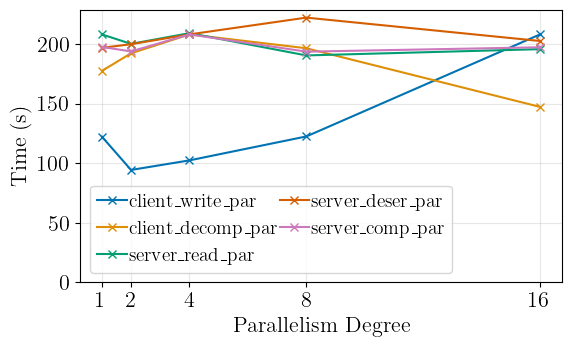

In [196]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# Preprocess the data (assuming `preprocess_df()` returns the preprocessed DataFrame)
df = preprocess_df()
df = df[df['table']=='lineitem_sf10']

# Define the environment (specific combination of server_cpu, client_cpu, and network)
server_cpu = 16
client_cpu = 2
network = 125

# List of parallelism parameters to scale
parallelism_params = ['client_write_par', 'client_decomp_par', 
                      'server_read_par', 'server_deser_par', 'server_comp_par']

# Default configuration (set all default parallelism values to 1)
default_config = {
    'client_write_par': 16,
    'client_decomp_par': 4,
    'server_read_par': 1,
    'server_deser_par': 4,
    'server_comp_par': 4
}

# Line styles for the compression types
line_styles = {
    'style': 'solid'
}

# Iterate over the systems to create separate plots

plt.figure(figsize=(6, 3.75))

# Filter the dataset for the environment and system, and for 'nocomp' compression
env_df = df[(df['server_cpu'] == server_cpu) & 
            (df['client_cpu'] == client_cpu) & 
            (df['network'] == network) & 
            (df['system'] == 'csv') & 
            (df['compression'] == 'snappy')]

all_x_ticks = set()  # Collect all unique x-ticks for the x-axis

# Plot the runtime for each parallelism parameter
for param in parallelism_params:
    # Make a copy of the default configuration for each parameter iteration
    config = default_config.copy()

    # Scale the current parameter (leave this one to vary)
    filtered_df = env_df.copy()

    # Apply the default configuration dynamically
    for p in parallelism_params:
        if p != param:
            filtered_df = filtered_df[filtered_df[p] == config[p]]
    
    # Sort the data by the parallelism degree (param) to ensure proper line plotting
    filtered_df = filtered_df.sort_values(by=param)
    #display(param)
    #display(filtered_df)

    # Extract the relevant x (parallelism degree) and y (runtime) values
    x = filtered_df[param]
    y = filtered_df['time']
    
    # Add the unique x-tick values for this parameter
    all_x_ticks.update(x.unique())
    
    # Plot the data with 'nocomp' compression type, using 'x' markers
    plt.plot(x, y, label=f'{param}', linestyle=line_styles['style'], marker='x', zorder=3)

# Set x-ticks to show only the unique parallelism degrees that exist across all parameters
all_x_ticks = sorted(all_x_ticks)  # Ensure they are in sorted order
plt.xticks(all_x_ticks, labels=[str(tick) for tick in all_x_ticks])
plt.ylim(0)  # Set the y-axis to start at 0

# Label the axes
plt.xlabel('Parallelism Degree')
plt.ylabel('Time (s)')
#plt.title(f'Runtime vs Parallelism Degree for {system} (nocomp)')

# Add legend
plt.legend(loc='best',ncol=2, columnspacing=0.1, handletextpad=0.1, handlelength=1.5)

# Add grid and improve layout
plt.grid(alpha=.3)
plt.tight_layout()

# Show the plot for the specific system or save it as a PDF
plt.savefig(f'opt_paper_plots/micro/par_scale_csv_csv_write_{default_config["client_write_par"]}_env_{server_cpu}_{client_cpu}_{network}.pdf', bbox_inches='tight')
#plt.show()


In [242]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Preprocess the data
filtered_df = preprocess_df()

# Define dataset map to replace the names
dataset_map = {
    'lineitem_sf10': 'lineitem',
    'ss13husallm': 'acs',
    'iotm': 'iot',
    'inputeventsm': 'icu'
}

# Define the two configurations to compare
config1 = {
    'client_write_par': 16,
    'client_decomp_par': 4,
    'server_read_par': 1,
    'server_deser_par': 4,
    'server_comp_par': 4,
    'compression': 'snappy'
}

config2 = {
    'client_write_par': 2,
    'client_decomp_par': 16,
    'server_read_par': 8,
    'server_deser_par': 1,
    'server_comp_par': 8,
    'compression': 'snappy'
}

# Define the environment we are working with
environment = {
    'server_cpu': 16,
    'client_cpu': 2,
    'network': 125,
    'system': 'csv'
}

# Filter the dataset for the current environment
filtered_df_env = filtered_df.copy()
for key, value in environment.items():
    filtered_df_env = filtered_df_env[filtered_df_env[key] == value]

# Replace the dataset names
filtered_df_env['table'] = filtered_df_env['table'].replace(dataset_map)

# List of datasets (tables)
datasets = filtered_df_env['table'].unique()

# Prepare runtime data for both configurations
config1_runtimes = []
config2_runtimes = []

# Filter and extract runtimes for config1
config1_df = filtered_df_env.copy()
for key, value in config1.items():
    config1_df = config1_df[config1_df[key] == value]
config1_runtimes = config1_df['time'].values

# Filter and extract runtimes for config2
config2_df = filtered_df_env.copy()
for key, value in config2.items():
    config2_df = config2_df[config2_df[key] == value]
config2_runtimes = config2_df['time'].valuesappend(7)

# Bar plot setup
x_indexes = np.arange(len(datasets))  # Set x-axis positions for each dataset
bar_width = 0.35  # Width of each bar

# Use Seaborn's colorblind-friendly palette
color_palette = sns.color_palette("colorblind", 2)  # One color for each configuration

# Create the bar plot
plt.figure(figsize=(6, 3.75))

# Plot bars for config1
plt.bar(x_indexes, config1_runtimes, width=bar_width, label='cc-config', color=color_palette[0])

# Plot bars for config2 (with an offset to place them next to config1)
plt.bar(x_indexes + bar_width, config2_runtimes, width=bar_width, label='cf-config', color=color_palette[1])

# Set x-ticks to the dataset names and position them in the center of the groups
plt.xticks(x_indexes + bar_width / 2, datasets)

# Label the axes
plt.xlabel('Dataset')
plt.ylabel('Runtime (s)')

plt.grid(axis='y', linestyle='--', alpha=0.4)

# Add a legend to differentiate between the two configurations
plt.legend(title='Configuration')

# Adjust the layout to avoid clipping
plt.tight_layout()

# Show the plot
#plt.show()
plt.savefig(f'opt_paper_plots/cf-cc-config_env_{server_cpu}_{client_cpu}_{network}.pdf', bbox_inches='tight')


IndexError: index 2 is out of bounds for axis 0 with size 0

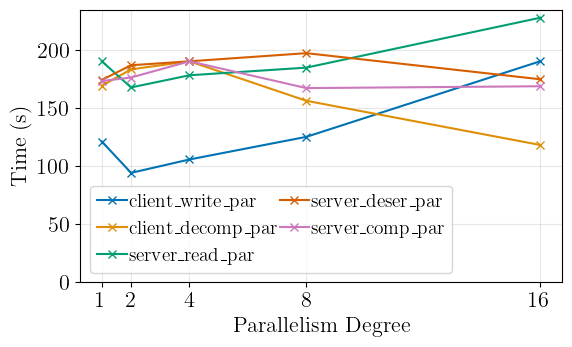

In [231]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# Preprocess the data (assuming `preprocess_df()` returns the preprocessed DataFrame)
df = preprocess_df()
df = df[df['table']=='lineitem_sf10']

# Define the environment (specific combination of server_cpu, client_cpu, and network)
server_cpu = 2
client_cpu = 2
network = 125

# List of parallelism parameters to scale
parallelism_params = ['client_write_par', 'client_decomp_par', 
                      'server_read_par', 'server_deser_par', 'server_comp_par']

# Default configuration (set all default parallelism values to 1)
default_config = {
    'client_write_par': 16,
    'client_decomp_par': 4,
    'server_read_par': 1,
    'server_deser_par': 4,
    'server_comp_par': 4
}

# Line styles for the compression types
line_styles = {
    'style': 'solid'
}

# Iterate over the systems to create separate plots

plt.figure(figsize=(6, 3.75))

# Filter the dataset for the environment and system, and for 'nocomp' compression
env_df = df[(df['server_cpu'] == server_cpu) & 
            (df['client_cpu'] == client_cpu) & 
            (df['network'] == network) & 
            (df['system'] == 'csv') & 
            (df['compression'] == 'snappy') & 
            (df['bufpool_size'] == 40*1024)
                ]

#display(env_df)
all_x_ticks = set()  # Collect all unique x-ticks for the x-axis

# Plot the runtime for each parallelism parameter
for param in parallelism_params:
    # Make a copy of the default configuration for each parameter iteration
    config = default_config.copy()

    # Scale the current parameter (leave this one to vary)
    filtered_df = env_df.copy()

    # Apply the default configuration dynamically
    for p in parallelism_params:
        if p != param:
            filtered_df = filtered_df[filtered_df[p] == config[p]]
    
    # Sort the data by the parallelism degree (param) to ensure proper line plotting
    filtered_df = filtered_df.sort_values(by=param)
    #display(param)
    #display(filtered_df)

    # Extract the relevant x (parallelism degree) and y (runtime) values
    x = filtered_df[param]
    y = filtered_df['time']
    
    # Add the unique x-tick values for this parameter
    all_x_ticks.update(x.unique())
    
    # Plot the data with 'nocomp' compression type, using 'x' markers
    plt.plot(x, y, label=f'{param}', linestyle=line_styles['style'], marker='x', zorder=3)

# Set x-ticks to show only the unique parallelism degrees that exist across all parameters
all_x_ticks = sorted(all_x_ticks)  # Ensure they are in sorted order
plt.xticks(all_x_ticks, labels=[str(tick) for tick in all_x_ticks])
plt.ylim(0)  # Set the y-axis to start at 0

# Label the axes
plt.xlabel('Parallelism Degree')
plt.ylabel('Time (s)')
#plt.title(f'Runtime vs Parallelism Degree for {system} (nocomp)')

# Add legend
plt.legend(loc='best',ncol=2, columnspacing=0.1, handletextpad=0.1, handlelength=1.5)

# Add grid and improve layout
plt.grid(alpha=.3)
plt.tight_layout()

# Show the plot for the specific system or save it as a PDF
plt.savefig(f'opt_paper_plots/micro/par_scale_csv_csv_write_{default_config["client_write_par"]}_env_{server_cpu}_{client_cpu}_{network}.pdf', bbox_inches='tight')
#plt.show()


[94.37  16.605 73.89  16.67 ]


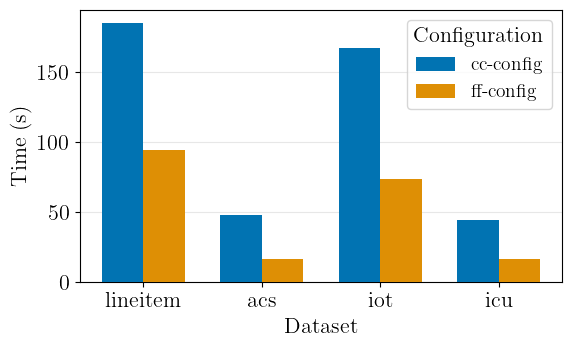

In [244]:
server_cpu = 2
client_cpu = 2
network = 125

# Preprocess the data
filtered_df = preprocess_df()

# Define dataset map to replace the names
dataset_map = {
    'lineitem_sf10': 'lineitem',
    'ss13husallm': 'acs',
    'iotm': 'iot',
    'inputeventsm': 'icu'
}

# Define the two configurations to compare
config1 = {
    'client_write_par': 16,
    'client_decomp_par': 4,
    'server_read_par': 1,
    'server_deser_par': 4,
    'server_comp_par': 4,
    'compression': 'snappy',
    'buff_size': 1024,
    'bufpool_size': 81920,
}

config2 = {
    'client_write_par': 2,
    'client_decomp_par': 16,
    'server_read_par': 2,
    'server_deser_par': 1,
    'server_comp_par': 8,
    'compression': 'snappy',
    'buff_size': 1024,
    'bufpool_size': 81920,
}

# Define the environment we are working with
environment = {
    'server_cpu': 2,
    'client_cpu': 2,
    'network': 125,
    'system': 'csv'
}

# Filter the dataset for the current environment
filtered_df_env = filtered_df.copy()
for key, value in environment.items():
    filtered_df_env = filtered_df_env[filtered_df_env[key] == value]

# Replace the dataset names
filtered_df_env['table'] = filtered_df_env['table'].replace(dataset_map)

# List of datasets (tables)

custom_order = ['lineitem', 'acs', 'iot', 'icu']
filtered_df_env['table'] = pd.Categorical(filtered_df_env['table'], categories=custom_order, ordered=True)
filtered_df_env = filtered_df_env.sort_values(by='table')
datasets = filtered_df_env['table'].unique()

# Prepare runtime data for both configurations
config1_runtimes = []
config2_runtimes = []

# Filter and extract runtimes for config1
config1_df = filtered_df_env.copy()
for key, value in config1.items():
    config1_df = config1_df[config1_df[key] == value]
#display(config1_df)
config1_runtimes = config1_df['time'].values

# Filter and extract runtimes for config2
config2_df = filtered_df_env.copy()
for key, value in config2.items():
    config2_df = config2_df[config2_df[key] == value]
config2_runtimes = config2_df['time'].values
config2_runtimes[2]=73.89

#display(config2_df)
#print(config1_runtimes)
print(config2_runtimes)
# Bar plot setup
x_indexes = np.arange(len(datasets))  # Set x-axis positions for each dataset
bar_width = 0.35  # Width of each bar

# Use Seaborn's colorblind-friendly palette
color_palette = sns.color_palette("colorblind", 2)  # One color for each configuration

# Create the bar plot
plt.figure(figsize=(6, 3.75))

# Plot bars for config1
plt.bar(x_indexes, config1_runtimes, width=bar_width, label='cc-config', color=color_palette[0], zorder=3)

# Plot bars for config2 (with an offset to place them next to config1)
plt.bar(x_indexes + bar_width, config2_runtimes, width=bar_width, label='ff-config', color=color_palette[1], zorder=3)

# Set x-ticks to the dataset names and position them in the center of the groups
plt.xticks(x_indexes + bar_width / 2, datasets)

# Label the axes
plt.xlabel('Dataset')
plt.ylabel('Time (s)')

plt.grid(axis='y', alpha=0.3)

# Add a legend to differentiate between the two configurations
plt.legend(title='Configuration')

# Adjust the layout to avoid clipping
plt.tight_layout()

# Show the plot
#plt.show()
plt.savefig(f'opt_paper_plots/micro/cc-ff-config_env_{server_cpu}_{client_cpu}_{network}.pdf', bbox_inches='tight')


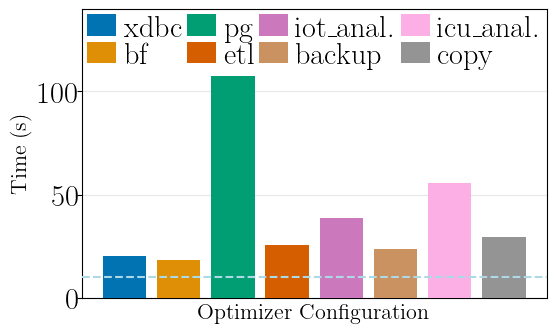

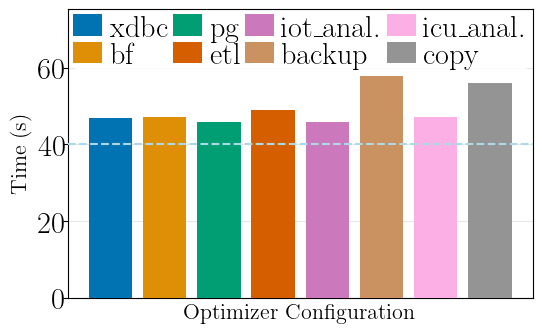

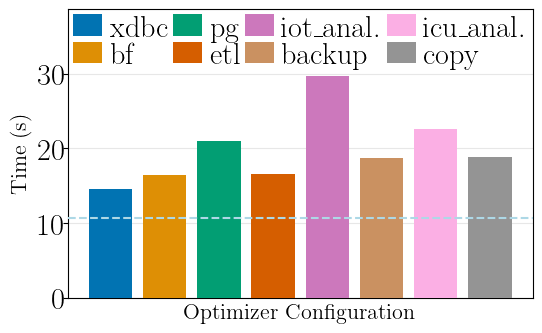

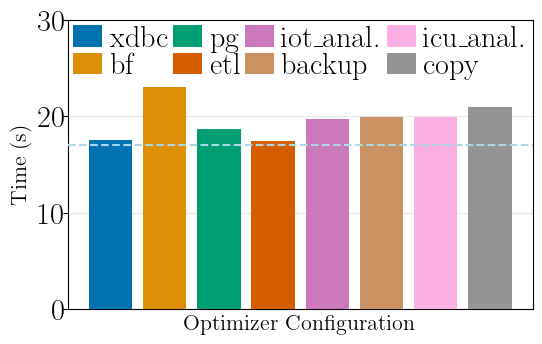

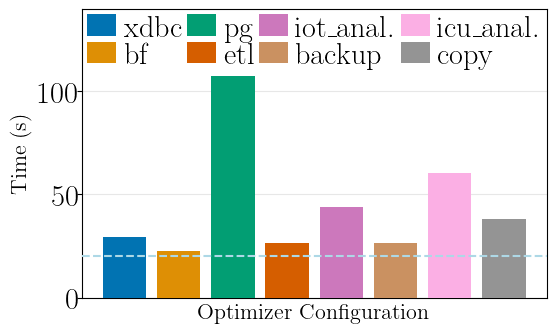

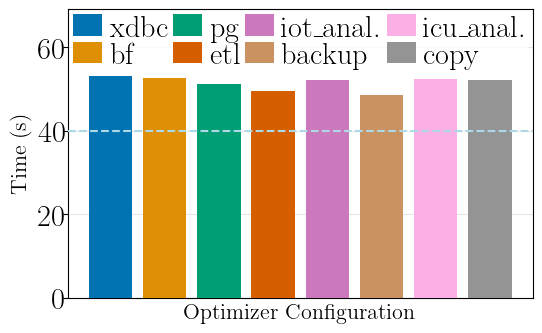

In [39]:
df = pd.read_csv('current_analysis/test_runs2.csv')
df['optimizer'] = df['optimizer'].replace('xdbc-bruteforce', 'bf')
df['optimizer'] = df['optimizer'].replace('xdbc-heuristic', 'xdbc')
#display(df)
#display(df)
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 22 
plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']
plt.rcParams.update({'font.size': 16, 'axes.labelsize': 16, 'axes.titlesize': 16, 'legend.fontsize': 14})

legend_fontsize=21.9
borderpad=0
labelspacing=0
borderaxespad=0.18
handlelength=.95
edgecolor='white'
frameon=True
# Define the custom sorting order for the optimizer column

#df['optimizer'] = df['optimizer'].cat.add_categories('expert_icu_anal.')
#df['optimizer'] = df['optimizer'].cat.add_categories('expert_iot_anal.')
df.loc[df['optimizer'] == 'expert_icu_analysis', 'optimizer'] = 'expert_icu_anal.'
df.loc[df['optimizer'] == 'expert_iot_analysis', 'optimizer'] = 'expert_iot_anal.'

custom_order = [
    'expert_copy', 'expert_icu_anal.', 'expert_backup', 
    'expert_iot_anal.', 'expert_etl', 'expert_pg', 'bf','xdbc'
]

# Convert the 'optimizer' column to a categorical type with the custom order
df['optimizer'] = pd.Categorical(df['optimizer'], categories=custom_order, ordered=True)

env_sizes = {
    'iot_analysis': 3667,
    'backup': 10935,
    'icu_analysis': 3601,
    'copy': 10473,
    'etl': 10473,
    'pg': 10473
}

env_bounds = {
    'iot_analysis': 17,
    'backup': 20,
    'icu_analysis': 10.7,
    'copy': 10,
    'etl': 40,
    'pg': 40
}



env_chars = {
    'iot_anal' : {
        'src_size': 3506,
        'compressed': 800,
        'bound' : 100,
        'reason' : 'slowest is pandas at 205MB/s, size 3500/205=17'
        
    },
    'backup' : {
        'src_size': 10000,
        'compressed': 2888,
        'bound' : 250,
        'reason' : 'serialization bound at 500MBps, size 10000/500=20'
        
    },
    'icu' : {
        'src_size': 2200,
        'compressed': 350,
        'bound' : 50,
        'reason': 'pandas bound at 205MB/s, size 2200/205=10.7'
    },
    'copy' : {
        'src_size': 10000,
        'compressed': 2000,
        'bound' : 0,
        'reason' : ''
    },
    'etl' : {
        'src_size': 10000,
        'compressed': 2000,
        'bound' : 500,
        '': '5serialization bound at 250MBps, size 10000/250=40'
    },
    'db_migr' : {
        'src_size': 10000,
        'compressed': 2000,
        'bound' : 100,
        'reason' : 'serialization bound at 250MBps, size 10000/250=40'
    }
    
    
}


# Sort the DataFrame according to the custom order
df = df.sort_values('optimizer')
# Get the unique environments
environments = df['env_name'].unique()

# Define a colorblind-friendly color palette
color_palette = sns.color_palette("colorblind")

# Iterate through each environment and create a plot
for env in environments:
    # Filter the DataFrame for the current environment
    env_df = df[df['env_name'] == env]

    # Extract optimizers and runtimes for this environment
    optimizers = env_df['optimizer'][::-1]
    runtimes = env_df['runtime'][::-1]
    #print(env)
    #print(runtimes)

    # Create a new figure for the environment
    plt.figure(figsize=(6, 3.75))

    # Plot each optimizer with a unique color from the colorblind-friendly palette
    bars = plt.bar(optimizers, runtimes, color=color_palette[:len(optimizers)], zorder=3)
    plt.axhline(y=env_bounds[env], color='lightblue', linestyle='--', linewidth=1.5, zorder=5)


    # Add titles and labels
    #plt.title(f'Runtime Comparison for {env}')
    plt.xlabel('Optimizer Configuration')
    plt.ylabel('Time (s)')
    plt.xticks([])
    plt.ylim(0, max(runtimes) * 1.3)
    plt.grid(axis='y', alpha=0.3)

    optimizers = optimizers.str.replace('expert_', '')
    # Create a legend for the optimizers
    plt.legend(bars, optimizers, labelspacing=labelspacing,ncols=4, handletextpad=0.25, columnspacing=0.15, 
               fontsize=legend_fontsize, loc='upper center', handlelength=handlelength,borderpad=borderpad, 
               borderaxespad=borderaxespad, frameon=frameon, edgecolor=edgecolor)

    ax = plt.gca()
    ax.tick_params(axis='y', pad=-2)
    # Save the figure as PNG
    plt.savefig(f'opt_paper_plots/optimizer_{env}.pdf', bbox_inches='tight', pad_inches=0.05)
    
    plt.show()
    plt.close()

In [22]:
import pandas as pd

# Read the CSV file (this contains the runtime and relevant data)
df_runs = pd.read_csv('current_analysis/test_runs2.csv')
df_csv = pd.read_csv('current_analysis/test_runs2.csv')
#df_runs.sort_values(by='optimizer', ascending=True, inplace=True)
#df_runs.reset_index(drop=True, inplace=True)
#display(df_runs)

#estimated_throughput = [('iot_analysis', 'xdbc-bruteforce', 506.22), ('iot_analysis', 'xdbc-heuristic', 368.1079999999999), ('backup', 'xdbc-bruteforce', 160.60500000000002), ('backup', 'xdbc-heuristic', 273.0285), ('icu_analysis', 'xdbc-bruteforce', 44.61), ('icu_analysis', 'xdbc-heuristic', 44.61), ('copy', 'xdbc-bruteforce', 451.7759999999999), ('copy', 'xdbc-heuristic', 451.7759999999999), ('etl', 'xdbc-bruteforce', 211.805), ('etl', 'xdbc-heuristic', 255.037), ('pg', 'xdbc-bruteforce', 204.07), ('pg', 'xdbc-heuristic', 204.07),('iot_analysis', 'xdbc', 368.1079999999999), ('iot_analysis', 'expert_iot_analysis', 219.44899999999996), ('iot_analysis', 'expert_backup', 417.6609999999999), ('iot_analysis', 'expert_icu_analysis', 219.44899999999996), ('iot_analysis', 'expert_copy', 219.44899999999996), ('iot_analysis', 'expert_etl', 417.6609999999999), ('iot_analysis', 'expert_pg', 219.28), ('backup', 'xdbc', 273.0285), ('backup', 'expert_iot_analysis', 160.60500000000002), ('backup', 'expert_backup', 160.60500000000002), ('backup', 'expert_icu_analysis', 141.406), ('backup', 'expert_copy', 160.60500000000002), ('backup', 'expert_etl', 160.60500000000002), ('backup', 'expert_pg', 83.18), ('icu_analysis', 'xdbc', 44.61), ('icu_analysis', 'expert_iot_analysis', 44.61), ('icu_analysis', 'expert_backup', 44.61), ('icu_analysis', 'expert_icu_analysis', 44.61), ('icu_analysis', 'expert_copy', 44.61), ('icu_analysis', 'expert_etl', 44.61), ('icu_analysis', 'expert_pg', 44.61), ('copy', 'xdbc', 451.7759999999999), ('copy', 'expert_iot_analysis', 208.51199999999994), ('copy', 'expert_backup', 634.2239999999999), ('copy', 'expert_icu_analysis', 147.696), ('copy', 'expert_copy', 269.328), ('copy', 'expert_etl', 512.5919999999999), ('copy', 'expert_pg', 86.88), ('etl', 'xdbc', 255.037), ('etl', 'expert_iot_analysis', 211.805), ('etl', 'expert_backup', 211.805), ('etl', 'expert_icu_analysis', 211.805), ('etl', 'expert_copy', 211.805), ('etl', 'expert_etl', 211.805), ('etl', 'expert_pg', 211.805), ('pg', 'xdbc', 204.07), ('pg', 'expert_iot_analysis', 204.07), ('pg', 'expert_backup', 204.07), ('pg', 'expert_icu_analysis', 204.07), ('pg', 'expert_copy', 204.07), ('pg', 'expert_etl', 204.07), ('pg', 'expert_pg', 204.07)]
#estimated_throughput = [('iot_analysis', 'xdbc-bruteforce', 377.97499999999997), ('iot_analysis', 'xdbc-heuristic', 377.97499999999997), ('backup', 'xdbc-bruteforce', 160.60500000000002), ('backup', 'xdbc-heuristic', 273.0285), ('icu_analysis', 'xdbc-bruteforce', 44.61), ('icu_analysis', 'xdbc-heuristic', 44.61), ('copy', 'xdbc-bruteforce', 451.7759999999999), ('copy', 'xdbc-heuristic', 451.7759999999999), ('etl', 'xdbc-bruteforce', 211.805), ('etl', 'xdbc-heuristic', 255.037), ('pg', 'xdbc-bruteforce', 204.07), ('pg', 'xdbc-heuristic', 204.07)]


# Create a DataFrame from the estimated throughput list
#df_estimated = pd.DataFrame(list(estimated_throughput), columns=['env_name', 'optimizer', 'est_throughput'])


# Dictionary of environment sizes (in MB, GB, etc. as applicable)
env_sizes = {
    'iot_analysis': 3667,
    'backup': 10935,
    'icu_analysis': 3601,
    'copy': 10473,
    'etl': 10473,
    'pg': 10473
}


# Map the size to the CSV DataFrame based on 'env_name'
df_runs['size'] = df_runs['env_name'].map(env_sizes)
#display(df_runs)
# Calculate real throughput (real throughput = size / runtime)
df_runs['real_throughput'] = df_runs['size'] / df_runs['runtime']
#display(df_runs)
# Merge the CSV with the estimated throughputs based on 'env_name' and 'optimizer'
#df_merged = pd.merge(df_csv, df_estimated[['env_name', 'optimizer', 'estimated_throughput']], on=['env_name', 'optimizer'], how='left')
#display(df_merged)
# Extract the lists of estimated and real throughputs, maintaining the same order
estimated_throughput = df_runs['est_throughput'].tolist()
real_throughput = df_runs['real_throughput'].tolist()

# Create a new DataFrame with the required columns
df_result = df_runs[['env_name', 'optimizer', 'est_throughput', 'real_throughput']]

# Rename the columns for clarity
df_result.columns = ['Environment Name', 'Optimizer', 'Estimated Throughput', 'Real Throughput']



/tmp/ipykernel_1026214/743223489.py:62: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scatter = plt.scatter(


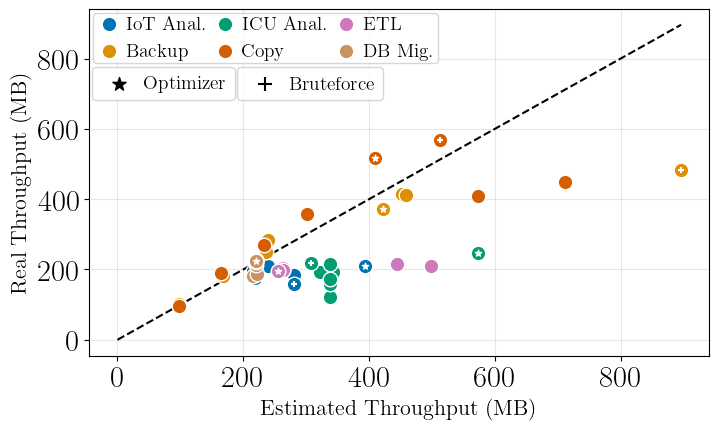

In [26]:

env_name_map = {
    'iot_analysis': 'IoT Anal.',
    'backup': 'Backup',
    'icu_analysis': 'ICU Anal.',
    'copy': 'Copy',
    'etl': 'ETL',
    'pg': 'DB Mig.'
}
#names = [env_name_map[env] for env in df_merged['env_name']]
names = [env_name_map[env] for env in df_runs['env_name']]
#names = ['IoT Anal.', 'Backup', 'ICU Anal.', 'Copy', 'ETL', 'DB Mig.']

#estimated_throughput = [368,273,44,451,211,204]
#real_throughput =      [203,295,157,551,205,193]

unique_env_names = list(env_name_map.values()) 

# Set colorblind-friendly palette
sns.set_palette("colorblind")
palette = sns.color_palette()

# Create a mapping from names to colors
name_color_map = {}
for i, name in enumerate(unique_env_names):
    name_color_map[name] = palette[i % len(palette)]
plt.figure(figsize=(8, 4.5))
marker_size = 110
scatter_points = []

zorder=3
# Plot each point individually to associate colors and names
for i in range(len(estimated_throughput)):
    if df_runs['optimizer'].iloc[i] != 'xdbc-heuristic' and df_runs['optimizer'].iloc[i] != 'xdbc-bruteforce':
        scatter = plt.scatter(
            estimated_throughput[i],
            real_throughput[i],
            color=name_color_map[names[i]],
            label=names[i],
            s=marker_size,
            edgecolor='white',zorder=zorder,
        )
    
    
        
        scatter_points.append(scatter)
zorder=3
for i in range(len(estimated_throughput)):    
    if df_runs['optimizer'].iloc[i] == 'xdbc-heuristic' or df_runs['optimizer'].iloc[i] == 'xdbc-bruteforce':

        scatter = plt.scatter(
            estimated_throughput[i],
            real_throughput[i],
            color=name_color_map[names[i]],
            label=names[i],
            s=marker_size,
            edgecolor='white',zorder=zorder,
        )
        markersymbol = '*'
        if df_runs['optimizer'].iloc[i] == 'xdbc-bruteforce':
            markersymbol = '+'
        
        scatter = plt.scatter(
            df_runs['est_throughput'].iloc[i],
            df_runs['real_throughput'].iloc[i],
            color='white',  # Transparent center
            edgecolor='white',  # Black hatch
            marker=markersymbol,  # Cross marker to simulate hatch
            s=marker_size / 5,  # Smaller size for the cross
            #linewidths=2,  # Thicker lines for the hatch
            zorder=zorder,  # Higher zorder to overlay it on top
        )
        zorder+=1
        scatter_points.append(scatter)
# Add y = x line
max_val = max(max(estimated_throughput), max(real_throughput))
plt.plot([0, max_val], [0, max_val], '--', color='black')
, label='Optimizer')
# Remove duplicate labels in legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
legend = plt.legend(by_label.values(), by_label.keys(), ncols=3, handletextpad=0.25, columnspacing=0.25, loc='upper left', handlelength=1.3,borderpad=.15, borderaxespad=0.2)
plt.grid(alpha=0.3)
# Labels and title
plt.xlabel('Estimated Throughput (MB)')
plt.ylabel('Real Throughput (MB)')


# Now, add the second legend with only the "Optimizer" entry
optimizer_scatter = plt.scatter([], [], color='black', marker='*', s=100, label='Optimizer')
optimizer_scatter2 = plt.scatter([], [], color='black', marker='+', s=100, label='BF')

# Create the second legend for "Optimizer", placing it in the bottom-left corner


# Re-add the first legend to ensure both legends are shown
plt.gca().add_artist(legend)
leg2 = plt.legend([optimizer_scatter], ['Optimizer'], bbox_to_anchor=(0.25, .86),handletextpad=.25)
plt.gca().add_artist(leg2)
plt.legend([optimizer_scatter2], ['Bruteforce'], bbox_to_anchor=(0.49, .86),handletextpad=.25)
# Show plot
#plt.show()
plt.savefig(f'opt_paper_plots/opt_cost_correlation.pdf', bbox_inches='tight', pad_inches=0.05)

In [971]:
from matplotlib.colors import to_rgba
import matplotlib.patches as mpatches



# Assuming df is already populated with your data
df = preprocess_df()
# Set the style of the visualization
#sns.set(style="whitegrid")

read_modes = [2]
environments = ['16-16-1000-0-0','16-2-125-0-0', '16-1-10-0-0','2-2-125-0-0','1-1-10-0-0']
#environments = ['1.0-16.0-10-0.0-0']
#tables = ['lineitem_sf10', 'ss13husallm', 'inputeventsm', 'iotm']
tables = ['lineitem_sf10', 'inputeventsm']
buffer_pool_sizes = [40 * 1024]  # Example buffer pool sizes
buffer_sizes = [32, 64, 128, 256, 512, 1024, 2048]  # Example buffer sizes

fixed_params = {
    '16-16-1000-0-0': {
        2: {
            "network_parallelism": 1,
            "client_write_par": 16,
            "client_decomp_par": 4,
            "server_read_partitions": 1,
            "server_read_par": 1,
            "server_deser_par": 4,
            "server_comp_par": 4,
        }
    },
    '16-2-125-0-0':
    {
        2: {
            "network_parallelism": 1,
            "client_write_par": 2,
            "client_decomp_par": 16,
            "server_read_partitions": 1,
            "server_read_par": 8,
            "server_deser_par": 1,
            "server_comp_par": 8,
        }
    },
    '16-1-10-0-0':
    {
        2: {
            "network_parallelism": 1,
            "client_write_par": 1,
            "client_decomp_par": 8,
            "server_read_partitions": 1,
            "server_read_par": 8,
            "server_deser_par": 1,
            "server_comp_par": 8,
        }
    },
    '2-2-125-0-0':
    {
        2: {
            "network_parallelism": 1,
            "client_write_par": 2,
            "client_decomp_par": 16,
            "server_read_partitions": 1,
            "server_read_par": 8,
            "server_deser_par": 1,
            "server_comp_par": 4,
        }
    },
    '1-1-10-0-0':
    {
        2: {
            "network_parallelism": 1,
            "client_write_par": 2,
            "client_decomp_par": 4,
            "server_read_partitions": 1,
            "server_read_par": 8,
            "server_deser_par": 1,
            "server_comp_par": 4,
        }
    }
}

# Get the unique compression methods and formats
unique_compressions = sorted(df['compression'].unique())
unique_formats = [1, 2]

# Generate a color palette based on the number of unique compressions
palette = sns.color_palette("colorblind", len(unique_compressions))

# Create a color map for each compression method
color_map = dict(zip(unique_compressions, palette))

# Create a custom color map with different opacities for each format
color_map_with_opacity = {}
for comp in unique_compressions:
    color_map_with_opacity[f'{comp}(row)'] = color_map[comp]
    color_map_with_opacity[f'{comp}(col)'] = tuple(np.clip(np.array(to_rgba(color_map[comp])[:3]) * 0.7, 0, 1))


# Function to create a grouped bar plot for runtime
def plot_grouped_bar(df, bufpool_size, env, table, client_readmode):
    plt.figure(figsize=(12, 6))
    bar_width = 0.4 / 2  # Adjust bar width to fit two bars within each group

    # Prepare data for plotting
    plot_data = []
    for buffer_size in buffer_sizes:
        for compression in unique_compressions:
            for fmt in unique_formats:
                subset = df[(df['bufpool_size'] == bufpool_size) &
                            (df['buff_size'] == buffer_size) &
                            (df['compression'] == compression) &
                            (df['format'] == fmt)]
                if not subset.empty:
                    mean_runtime = subset['time'].mean()
                    plot_data.append((buffer_size, compression, fmt, mean_runtime))

    # Convert to DataFrame for plotting
    plot_df = pd.DataFrame(plot_data, columns=['Buffer Size', 'Compression', 'Format', 'Runtime'])

    plot_df.sort_values(by=['Buffer Size', 'Compression', 'Format'], inplace=True)
    # Combine Compression and Format for unique hue
    plot_df['Compression_Format'] = plot_df['Compression'].astype(str) + np.where(plot_df['Format'] == 1, '(row)', '(col)')
    
    # Plot grouped bar plot
    bar_plot = sns.barplot(x='Buffer Size', y='Runtime', hue='Compression_Format', data=plot_df, dodge=True, palette=color_map_with_opacity)

    # Add titles and labels
    plt.xlabel('Buffer Size (KB)')
    plt.ylabel('Time (s)')
    plt.legend(ncol=5, fontsize=legend_fontsize, columnspacing=0.08, handletextpad=0.08, handlelength=handlelength, borderaxespad=borderaxespad, borderpad=borderpad, labelspacing=labelspacing, frameon=frameon, edgecolor=edgecolor)
    plt.grid(axis='y', alpha=0.3)
    


    print(f"Env: {env}, Table: {table}, bufpool size: {bufpool_size}, mode: {client_readmode} Runtime:")
    # Show the plot
    plt.tight_layout()
    if save==0:
        plt.show()
    else:
        plt.savefig(f'opt_paper_plots/micro/compression_memory_runtimes_{env}_{table}_{client_readmode}.pdf', bbox_inches='tight')

# Function to create a grouped bar plot for datasize
def plot_grouped_bar_datasize(df, bufpool_size, env, table, client_readmode):
    plt.figure(figsize=(12, 6))
    bar_width = 0.4 / 2  # Adjust bar width to fit two bars within each group

    # Prepare data for plotting
    plot_data = []
    for buffer_size in buffer_sizes:
        for compression in unique_compressions:
            for fmt in unique_formats:
                subset = df[(df['bufpool_size'] == bufpool_size) &
                            (df['buff_size'] == buffer_size) &
                            (df['compression'] == compression) &
                            (df['format'] == fmt)]
                if not subset.empty:
                    mean_datasize = (subset['datasize'].mean() / (1024 * 1024)/1024)  # Convert bytes to megabytes, gigabytes
                    plot_data.append((buffer_size, compression, fmt, mean_datasize))

    # Convert to DataFrame for plotting
    plot_df = pd.DataFrame(plot_data, columns=['Buffer Size', 'Compression', 'Format', 'Data Size (GB)'])
    plot_df.sort_values(by=['Buffer Size', 'Compression', 'Format'], inplace=True)

    # Combine Compression and Format for unique hue
    plot_df['Compression_Format'] = plot_df['Compression'].astype(str) + np.where(plot_df['Format'] == 1, '(row)', '(col)')

    # Plot grouped bar plot
    bar_plot = sns.barplot(x='Buffer Size', y='Data Size (GB)', hue='Compression_Format', data=plot_df, dodge=True, palette=color_map_with_opacity)
    plt.grid(axis='y', alpha=0.3)


    # Add titles and labels
    plt.xlabel('Buffer Size (KB)')
    plt.ylabel('Data Size (GB)')
    plt.legend(ncol=5, fontsize=legend_fontsize, columnspacing=0.08, handletextpad=0.08, handlelength=handlelength, borderaxespad=borderaxespad, borderpad=borderpad, labelspacing=labelspacing, frameon=frameon, edgecolor=edgecolor)
    
    # Show the plot
    plt.tight_layout()
    print(f"Env: {env}, Table: {table}, bufpool size: {bufpool_size}, mode: {client_readmode} Datasize:")
    if save==0:
        plt.show()
    else:
        plt.savefig(f'opt_paper_plots/micro/compression_memory_datasizes_{env}_{table}_{client_readmode}.pdf', bbox_inches='tight')



Env: 16-16-1000-0-0, Table: lineitem_sf10, bufpool size: 40960, mode: 2 Runtime:


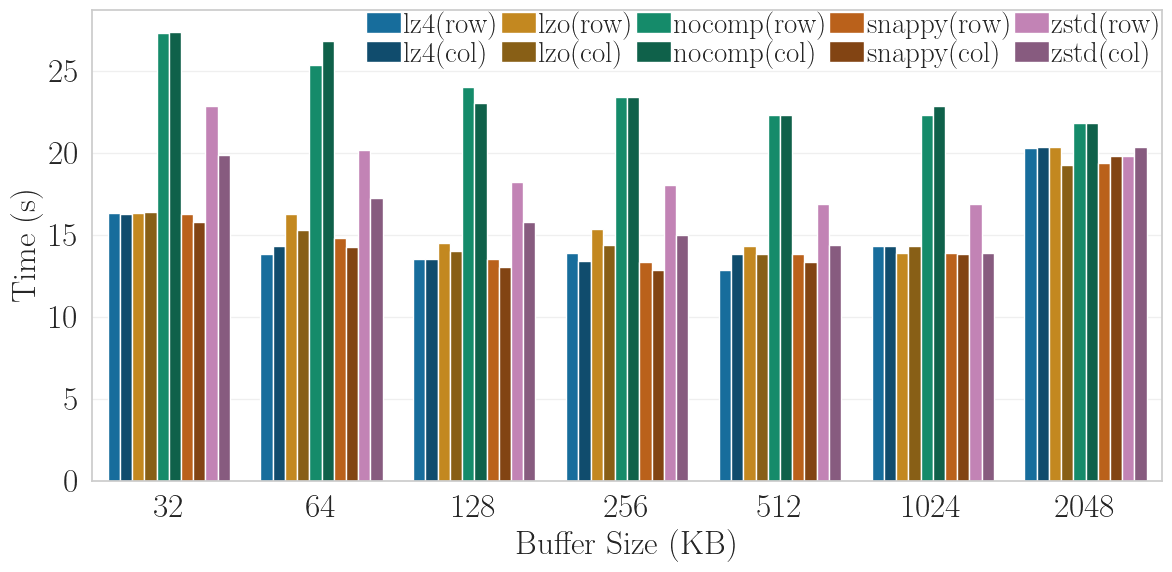

Env: 16-16-1000-0-0, Table: lineitem_sf10, bufpool size: 40960, mode: 2 Datasize:


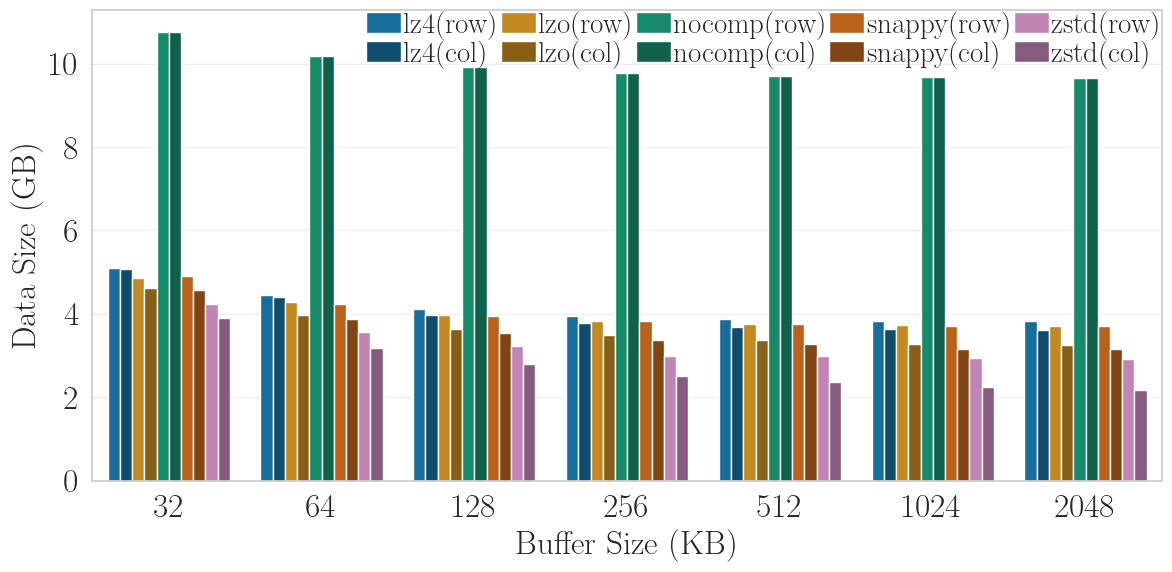

Env: 16-16-1000-0-0, Table: inputeventsm, bufpool size: 40960, mode: 2 Runtime:


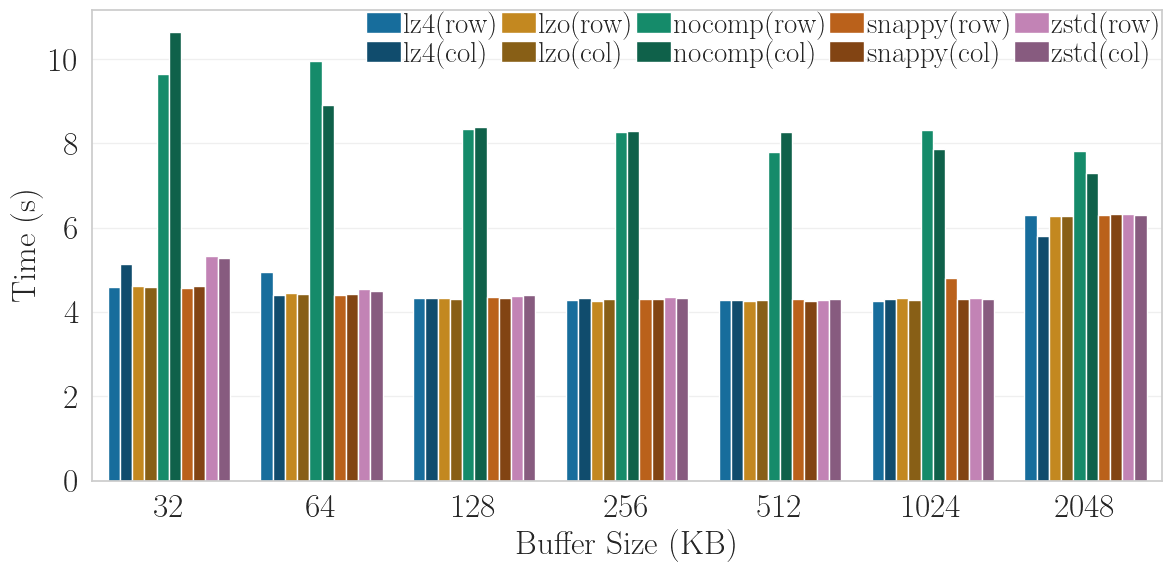

Env: 16-16-1000-0-0, Table: inputeventsm, bufpool size: 40960, mode: 2 Datasize:


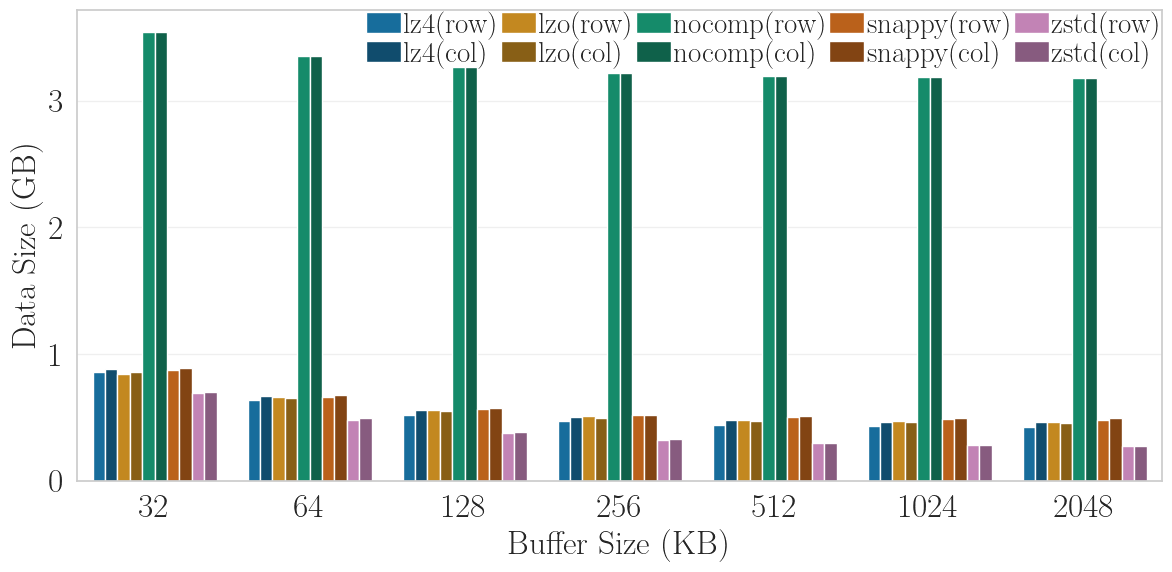

Env: 16-2-125-0-0, Table: lineitem_sf10, bufpool size: 40960, mode: 2 Runtime:


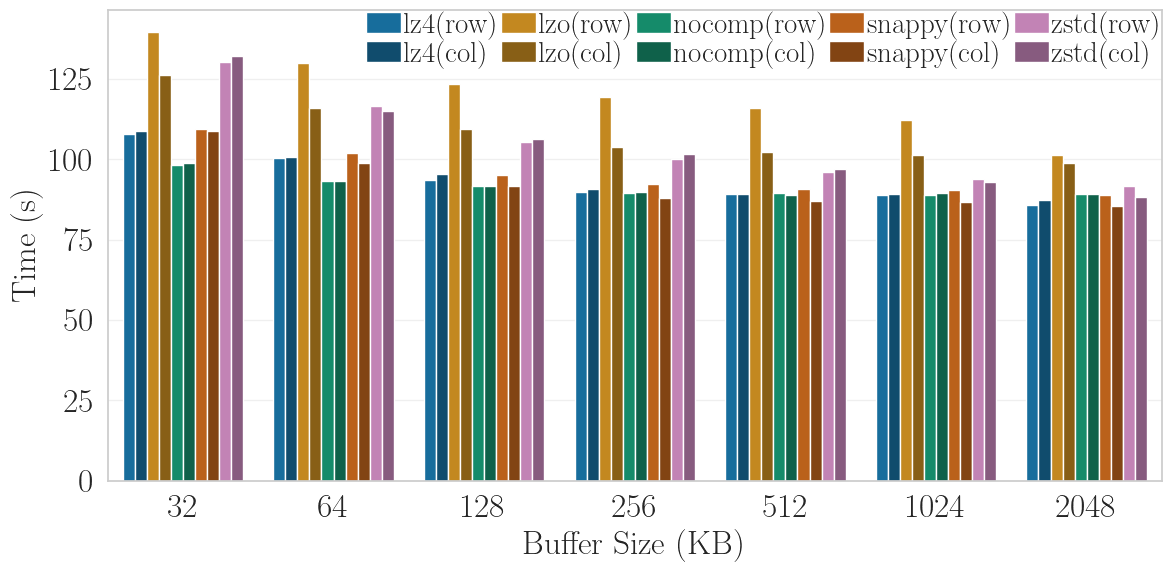

Env: 16-2-125-0-0, Table: lineitem_sf10, bufpool size: 40960, mode: 2 Datasize:


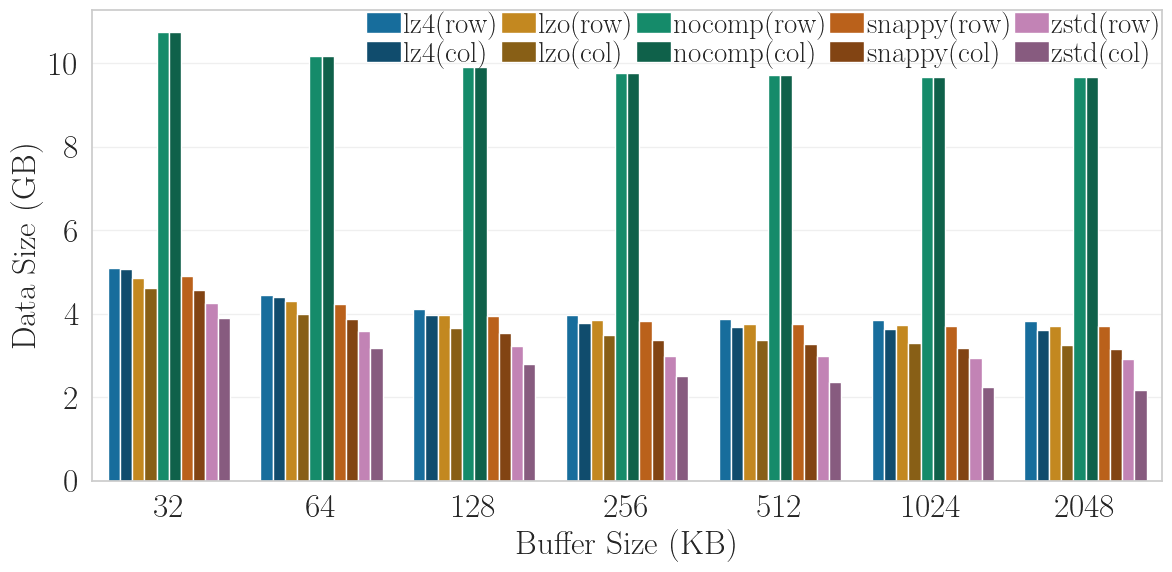

Env: 16-2-125-0-0, Table: inputeventsm, bufpool size: 40960, mode: 2 Runtime:


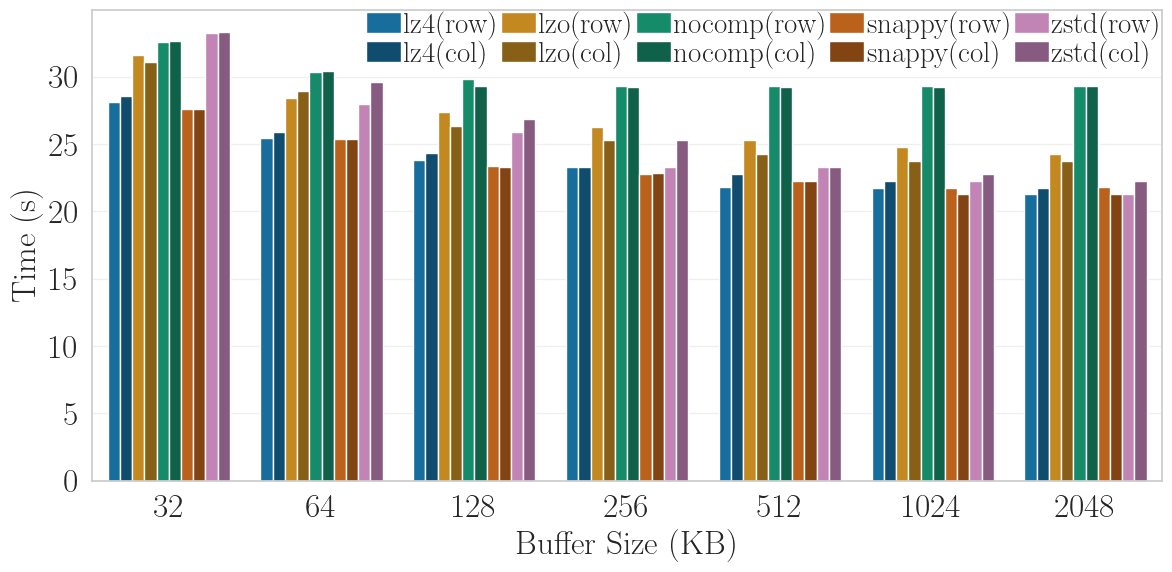

Env: 16-2-125-0-0, Table: inputeventsm, bufpool size: 40960, mode: 2 Datasize:


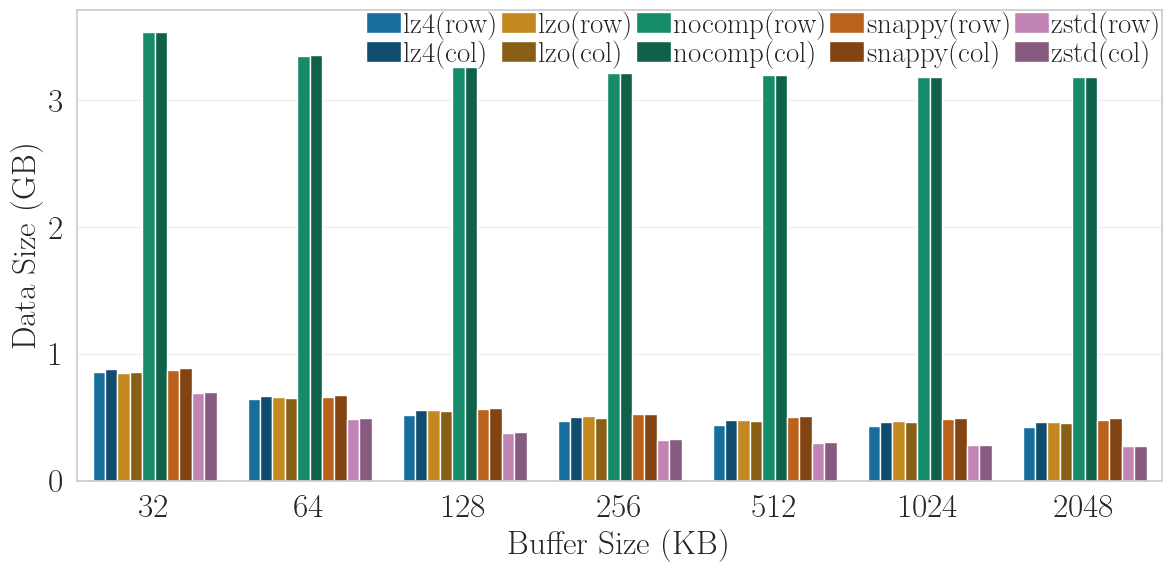

Env: 16-1-10-0-0, Table: lineitem_sf10, bufpool size: 40960, mode: 2 Runtime:


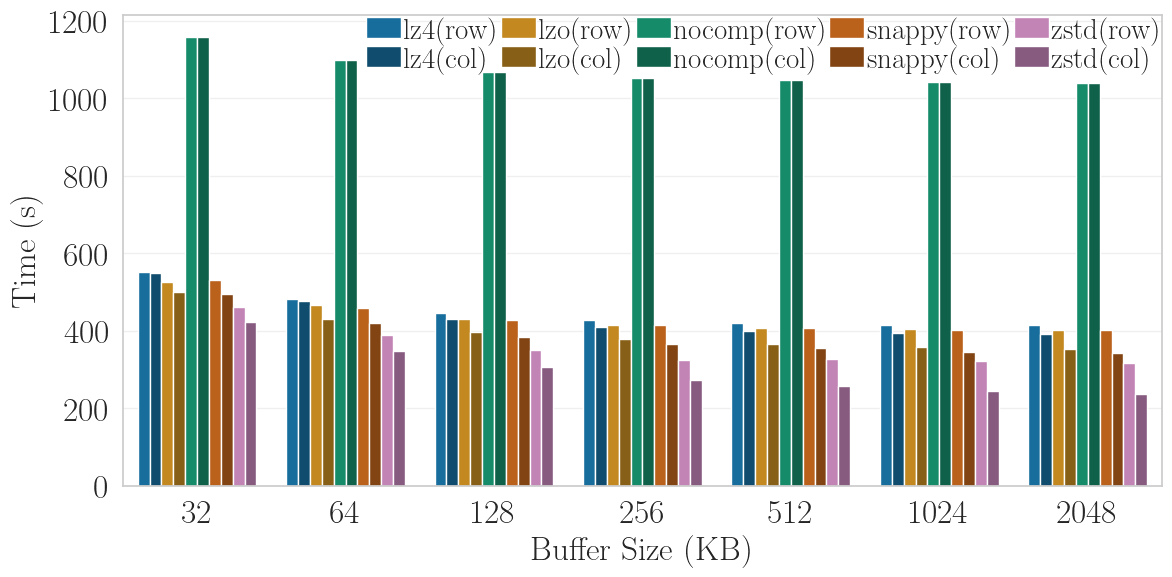

Env: 16-1-10-0-0, Table: lineitem_sf10, bufpool size: 40960, mode: 2 Datasize:


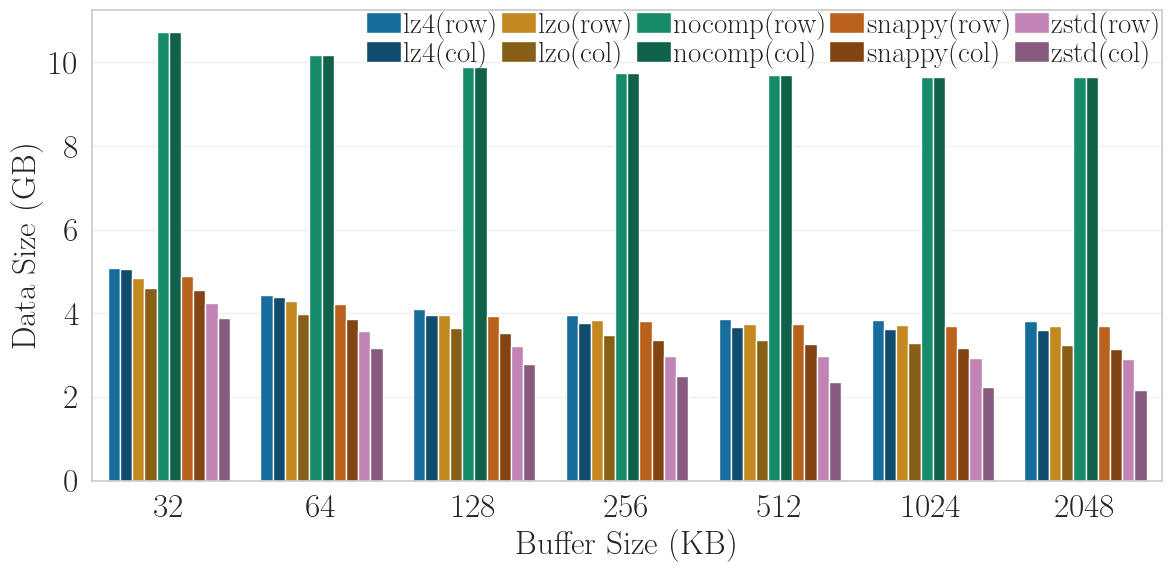

Env: 16-1-10-0-0, Table: inputeventsm, bufpool size: 40960, mode: 2 Runtime:


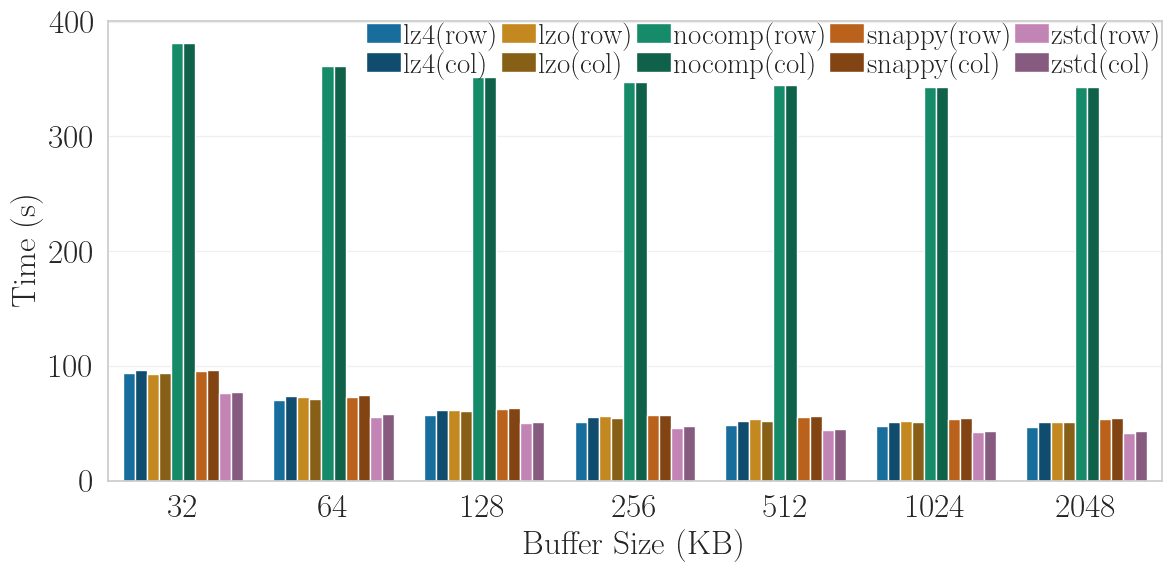

Env: 16-1-10-0-0, Table: inputeventsm, bufpool size: 40960, mode: 2 Datasize:


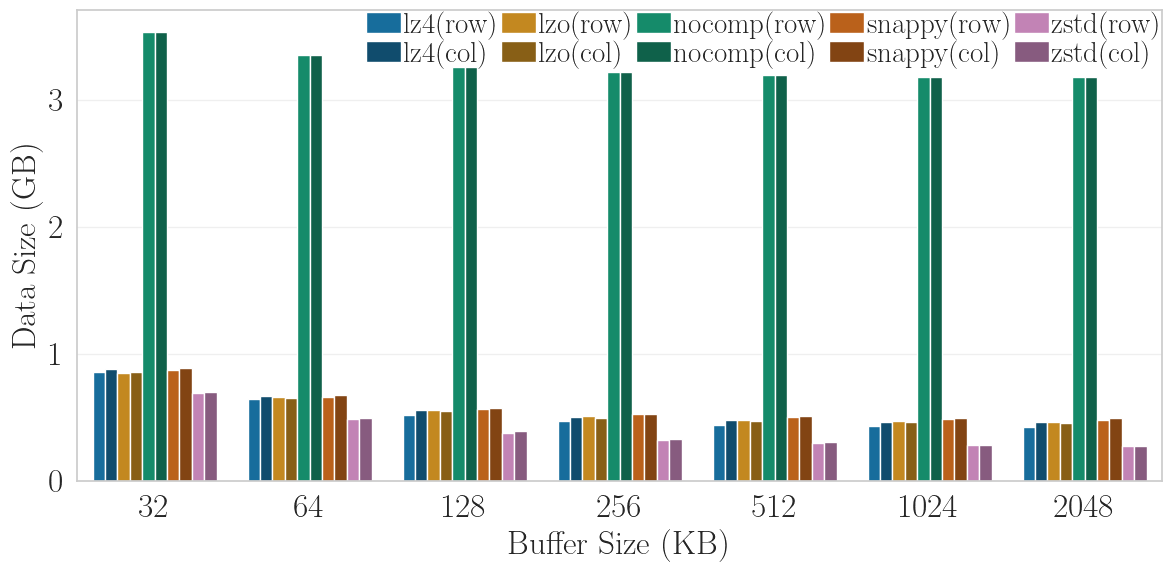

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Env: 2-2-125-0-0, Table: lineitem_sf10, bufpool size: 40960, mode: 2 Runtime:


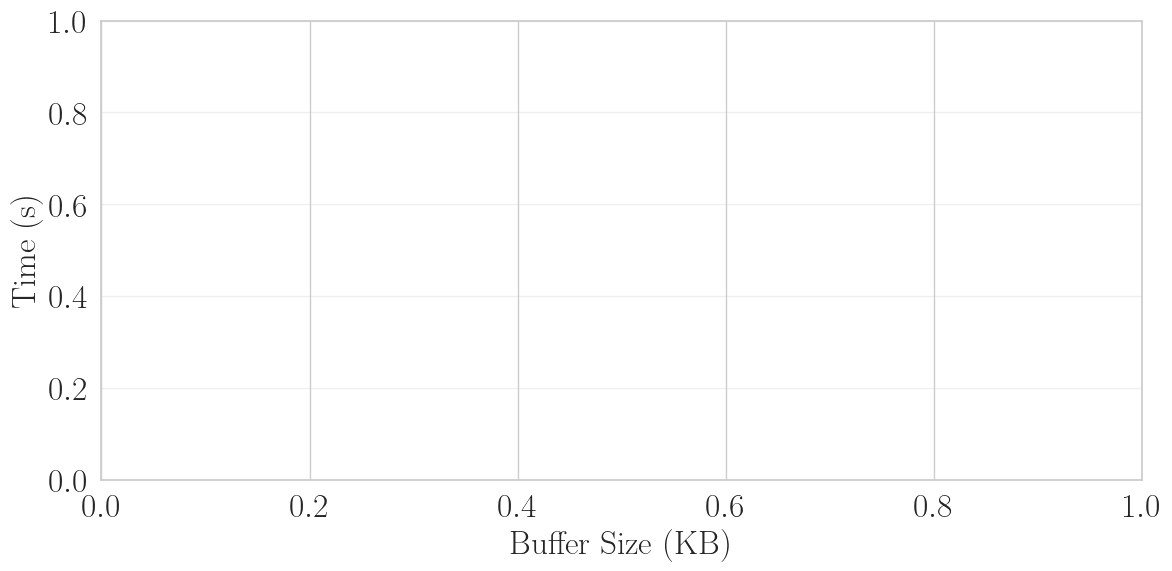

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Env: 2-2-125-0-0, Table: lineitem_sf10, bufpool size: 40960, mode: 2 Datasize:


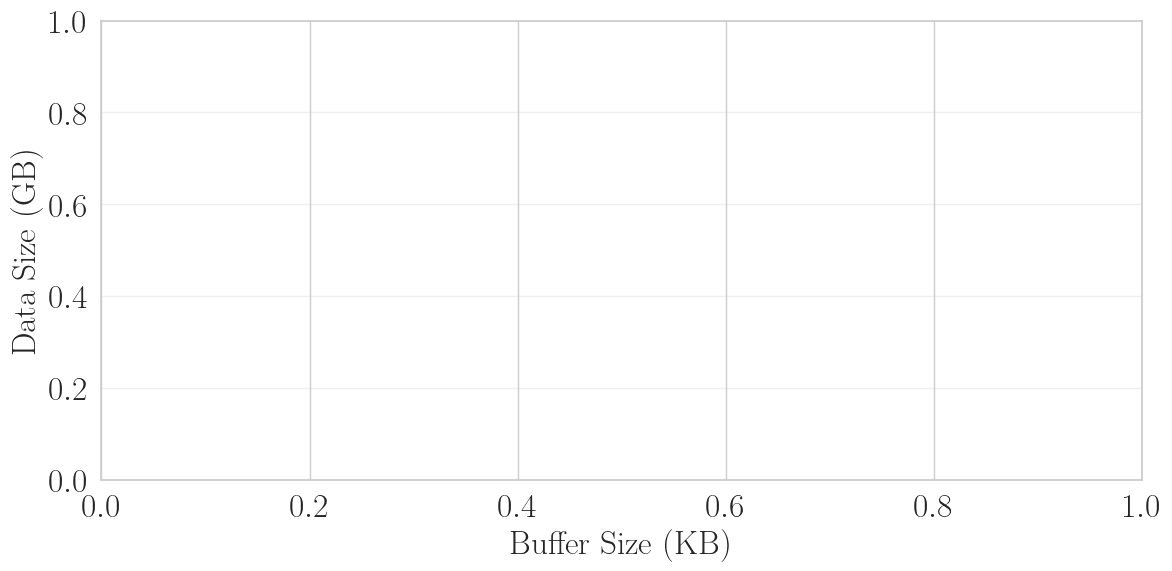

Env: 2-2-125-0-0, Table: inputeventsm, bufpool size: 40960, mode: 2 Runtime:


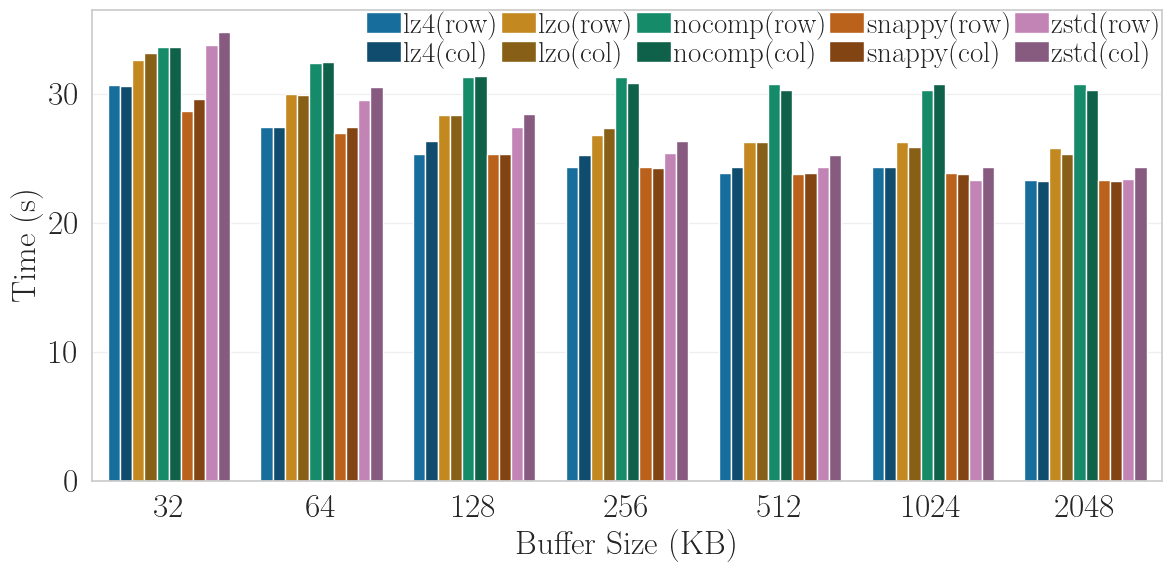

Env: 2-2-125-0-0, Table: inputeventsm, bufpool size: 40960, mode: 2 Datasize:


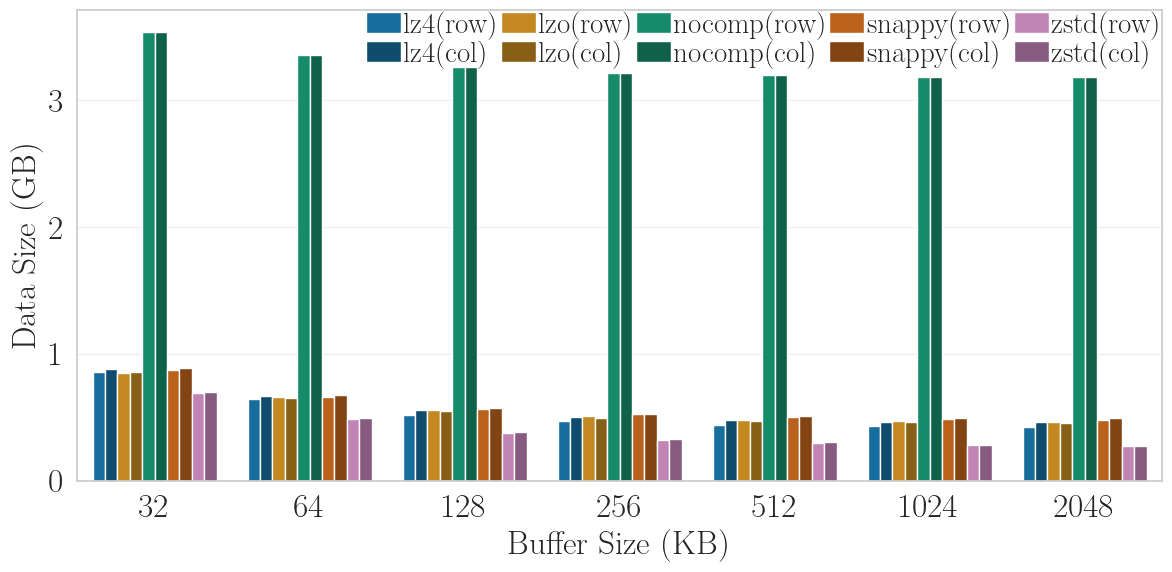

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Env: 1-1-10-0-0, Table: lineitem_sf10, bufpool size: 40960, mode: 2 Runtime:


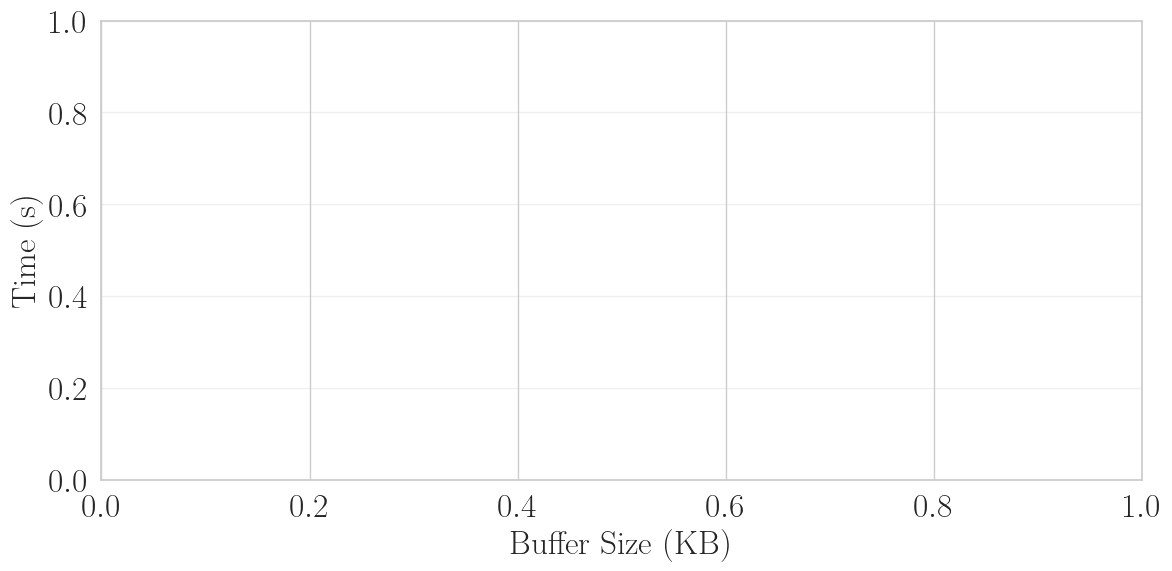

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Env: 1-1-10-0-0, Table: lineitem_sf10, bufpool size: 40960, mode: 2 Datasize:


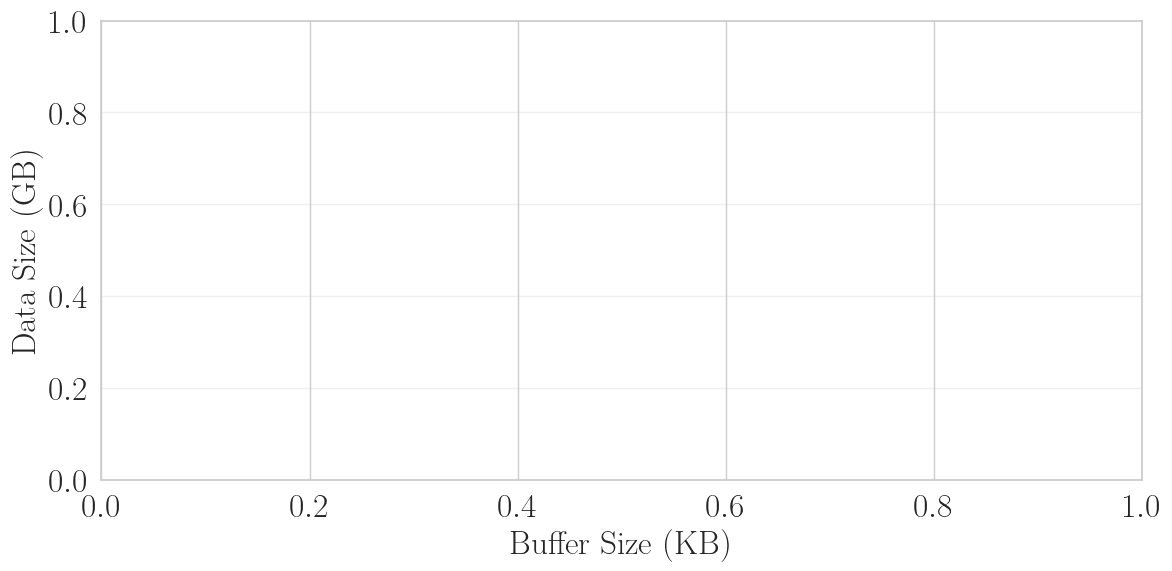

Env: 1-1-10-0-0, Table: inputeventsm, bufpool size: 40960, mode: 2 Runtime:


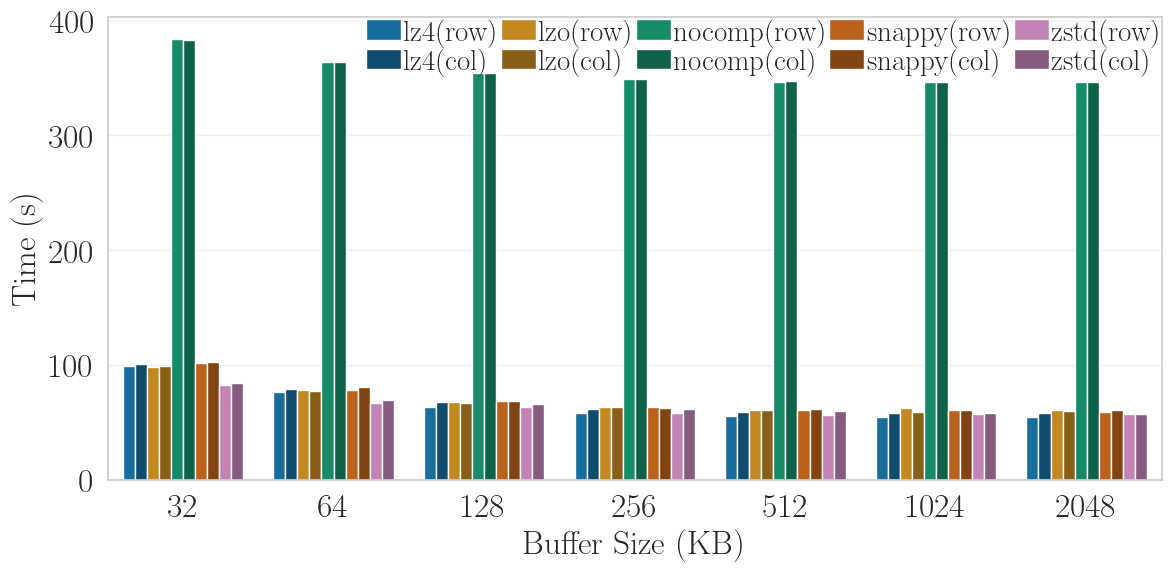

Env: 1-1-10-0-0, Table: inputeventsm, bufpool size: 40960, mode: 2 Datasize:


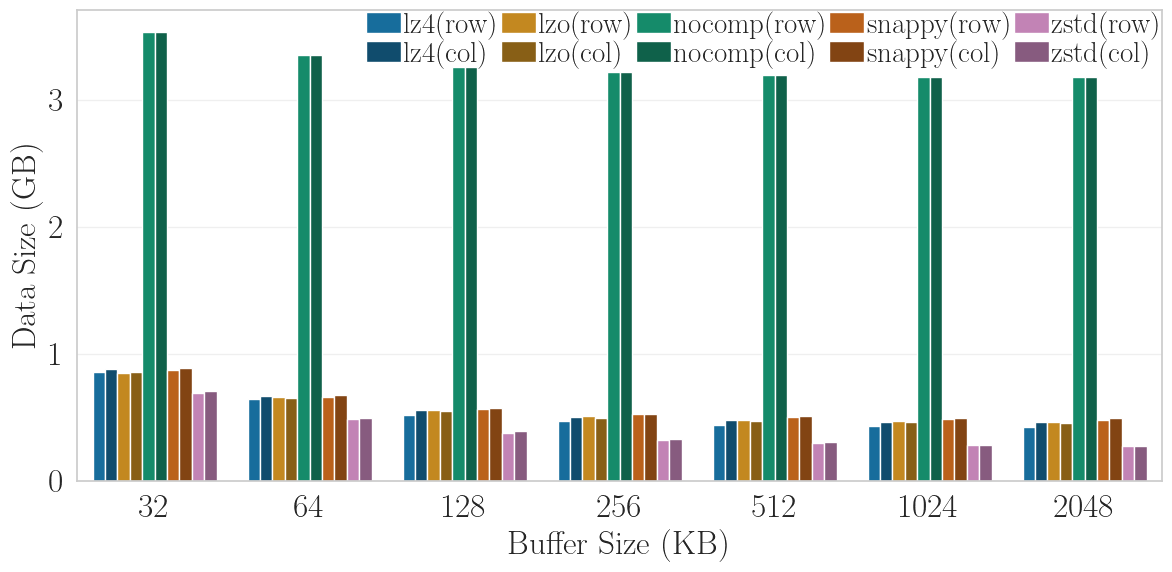

In [976]:
# Create plots for each combination of client_readmode, env, and bufpool_size
save=0
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 24 
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
legend_fontsize=21
borderpad=0.03
labelspacing=0
borderaxespad=0
handlelength=1.2
edgecolor='gainsboro'
frameon=False
client_readmode=2
for env in environments:
    for table in tables:
        for bufpool_size in buffer_pool_sizes:
            # Filter data for the current combination
            #display(fixed_params[env][client_readmode])
            
            filtered_df = df[
                (df['table'] == table) &
                (df['client_readmode'] == client_readmode) &
                (df['server_cpu'] == int(env.split("-")[0])) &
                (df['client_cpu'] == int(env.split("-")[1])) &
                (df['network'] == int(env.split("-")[2])) &
                (df['bufpool_size'] == bufpool_size) &
                (df['network_parallelism'] == fixed_params[env][client_readmode]["network_parallelism"]) &
                (df['client_write_par'] == fixed_params[env][client_readmode]["client_write_par"]) &
                (df['client_decomp_par'] == fixed_params[env][client_readmode]["client_decomp_par"]) &
                (df['server_read_partitions'] == fixed_params[env][client_readmode]["server_read_partitions"]) &
                (df['server_read_par'] == fixed_params[env][client_readmode]["server_read_par"]) &
                (df['server_deser_par'] == fixed_params[env][client_readmode]["server_deser_par"]) &
                (df['server_comp_par'] == fixed_params[env][client_readmode]["server_comp_par"])
            ].copy()  # Create a copy to avoid SettingWithCopyWarning

            #display(filtered_df)
            # Plot grouped bar plot for the current buffer pool size
            plot_grouped_bar(filtered_df, bufpool_size, env, table, client_readmode)
            
            # Plot grouped bar plot for datasize for the current buffer pool size
            plot_grouped_bar_datasize(filtered_df, bufpool_size, env, table, client_readmode)


 Environment: 16-16-1000
Optimal Settings Buffer Pool Size: 16384 MB, Buffer Size: 256 KB, Time: 12.89 s
 Environment: 16-2-125
Optimal Settings Buffer Pool Size: 8192 MB, Buffer Size: 1024 KB, Time: 92.36500000000001 s


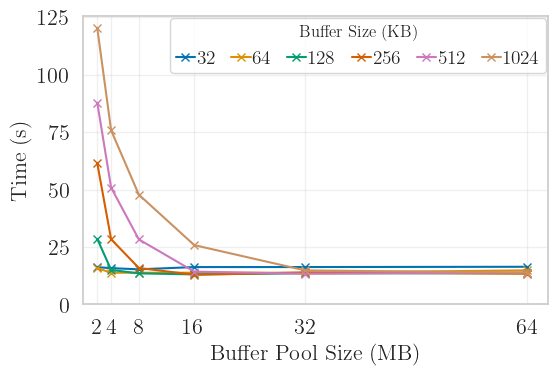

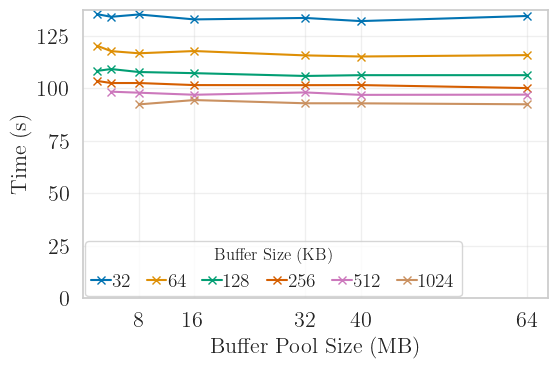

In [752]:

load_df = preprocess_df()
# Load the original dataframe


# Configuration dictionary

config = {

    '1':{
        'server_cpu': 16,
        'client_cpu': 16,
        'network': 1000,
        'table': 'lineitem_sf10',
        "network_parallelism": 1,
        "client_write_par": 16,
        "client_decomp_par": 4,
        "server_read_partitions": 1,
        "server_read_par": 1,
        "server_deser_par": 8,
        "server_comp_par": 4,
        "format":1,
        'compression': 'lz4'
    },
    '2':{
        'server_cpu': 16,
        'client_cpu': 2,
        'network': 125,
        'table': 'lineitem_sf10',
        "network_parallelism": 1,
        "client_write_par": 2,
        "client_decomp_par": 16,
        "server_read_partitions": 1,
        "server_read_par": 8,
        "server_deser_par": 1,
        "server_comp_par": 8,
        'compression': 'zstd',
        "format":2,
        }
}

# Make a copy of the original dataframe to filter


for key,config in config.items():
    filtered_df = load_df.copy()
    filtered_df = filtered_df[filtered_df['buff_size'] <=1024]
# Apply all filters from config2 iteratively
    for key, value in config.items():
        filtered_df = filtered_df[filtered_df[key] == value]
        #print(f"filtering {key}")
        #display(filtered_df)
    #display(filtered_df)
    # Create a new dataframe `df` containing only the filtered rows
    #df = filtered_df.copy()
    plt.figure(figsize=(6, 3.75))
    
    # Unique buffer sizes
    unique_buff_sizes = sorted(filtered_df['buff_size'].unique())
    
    # Plot data for each buff_size
    optimal_settings = pd.DataFrame([])
    for buff_size in unique_buff_sizes:
        subset = filtered_df[filtered_df['buff_size'] == buff_size]
        mean_time = subset.groupby('bufpool_size')['time'].mean().reset_index()
    
        # Plot line for current buffer size
        plt.plot(mean_time['bufpool_size'], mean_time['time'], marker='x', linestyle='-', label=f'{buff_size}')
        # Find the minimum transfer time and corresponding buffer sizes
        min_time = filtered_df['time'].min()
        optimal_settings = filtered_df[filtered_df['time'] == min_time]
    env = f"{config['server_cpu']}-{config['client_cpu']}-{config['network']}"
    print(f" Environment: {env}")
    for index, row in optimal_settings.iterrows():
        print(f"Optimal Settings Buffer Pool Size: {row['bufpool_size']} MB, Buffer Size: {row['buff_size']} KB, Time: {min_time} s")
    # Adding title and labels
    #plt.title(f'Impact of Buffer Pool Size and Buffer Size on Transfer Time\nClient Read Mode: {client_readmode}, Environment: {env}')
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.xlabel('Buffer Pool Size (MB)')
    plt.ylabel('Time (s)')
    
    # Converting bufpool_size to MB for readability
    plt.xticks(mean_time['bufpool_size'], [f"{x // 1024}" for x in mean_time['bufpool_size']])
    
    # Adding legend
    plt.legend(title='Buffer Size (KB)', ncol=6, columnspacing=0.8, handletextpad=0.08, handlelength=1, borderaxespad=0.1, borderpad=0.3)
    
    # Adding grid
    plt.grid(alpha=.3)
    
    # Show plot
    #plt.show()
    plt.savefig(f'opt_paper_plots/micro/buffer_vs_bufferpool_{env}_{config["table"]}.pdf', bbox_inches='tight')

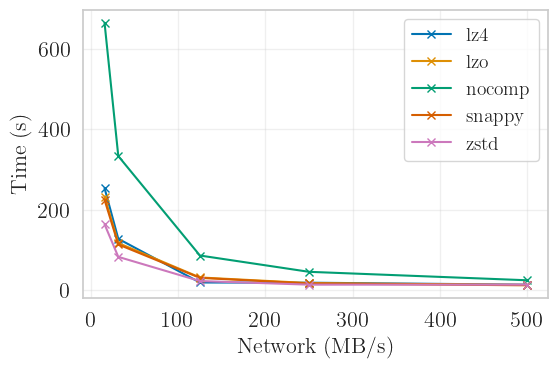

In [758]:

filtered_df = preprocess_df()
# Load the original dataframe
#display(load_df)



config = {
        'server_cpu': 16,
        'client_cpu': 16,
        'table': 'lineitem_sf10',
        "network_parallelism": 1,
        "client_write_par": 16,
        "client_decomp_par": 4,
        "server_read_partitions": 1,
        "server_read_par": 1,
        "server_deser_par": 4,
        "server_comp_par": 4,
        "format":2,
        "bufpool_size": 40960,
        "buff_size": 512
}

for key, value in config.items():
    filtered_df = filtered_df[filtered_df[key] == value]

filtered_df = filtered_df[filtered_df['network'].isin([15.75, 31.5, 125, 250, 500])]
plt.figure(figsize=(6, 3.75))
unique_compressions = sorted(filtered_df['compression'].unique())
for compression in unique_compressions:
    subset = filtered_df[filtered_df['compression'] == compression]
    plt.plot(subset['network'], subset['time'], marker='x', label=compression, linestyle='-', 
             markerfacecolor='none', markeredgewidth=1)

env = f"{config['server_cpu']}-{config['client_cpu']}"

#plt.xticks(ticks=[15.75, 31.5,62, 125, 250, 500], labels=[15.75, 31.5,62, 125, 250, 500], rotation=45)
# Add labels and title
#plt.title('Runtime vs Network with Different Compression Types')
plt.xlabel('Network (MB/s)')
plt.ylabel('Time (s)')
plt.grid(alpha=.3)
plt.legend()
# Show the plot
#plt.show()
plt.savefig(f'opt_paper_plots/micro/network_vs_comp_{env}_{config["table"]}.pdf', bbox_inches='tight')

    